# Setting up program

## Imports

In [4]:
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))

import scipy
from scipy.cluster.hierarchy import linkage, dendrogram
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import math
import pandas as pd
import pickle

import config
from config import BasePaths
from CellLineWork.CellLineExpressionMatrix import CellLineExpressionMatrix

## Upload preprocessed matrix
1. Normalize read counts per cell (divide by sum of reads in cell)
2. Change to TPM values (x10^6)
3. Filter cells (>4000 non zero genes)
4. Filter genes (log2(mean(TPM)+1)>=3
5. Transform values to log TMP by log2((TPM/10)+1)
6. Center values per gene

In [6]:
exp_obj = CellLineExpressionMatrix().execute()

Logging into /Users/iriskalka/Dropbox (Weizmann Institute)/CacheCopy/PipelineCache/10xExpressionMatrix2018_05_01_13_28.log


# Separating to cell lines

In [ ]:
import nbconvert
nbconvert.

# Clustering

In [9]:
def create_clustering(expression_mat, show=False, p=100):
    # Create correlation based distance matrix
    corr_dist_matrix = scipy.spatial.distance.cdist(expression_mat.transpose(), 
                                                    expression_mat.transpose(), 'correlation')
    corr_dist_condensed = scipy.spatial.distance.pdist(expression_mat.transpose(), metric='correlation')
    
    print(corr_dist_matrix.shape, len(corr_dist_condensed), 
          expression_mat.shape, expression_mat.shape[1]*(expression_mat.shape[1]-1)/2)
    # Create tree
    corr_tree = linkage(corr_dist_condensed, method='average')

    # Create dendrogram
    corr_dn = dendrogram(corr_tree)
    
    if show:
        fig, ax = plt.subplots()
        ax.set_title('Hierarchical Clustering Dendrogram (truncated)')
        ax.set_xlabel('sample index')
        ax.set_ylabel('distance')
        dendrogram(
            corr_tree,
            truncate_mode='lastp',  # show only the last p merged clusters
            p=p,  # show only the last p merged clusters
            show_leaf_counts=False,  # otherwise numbers in brackets are counts
            leaf_rotation=90.,
            leaf_font_size=12.,
            show_contracted=True,  # to get a distribution impression in truncated branches
            ax=ax
        )
        plt.show()
    return corr_dist_matrix, corr_tree, corr_dn

In [10]:
def show_correlation_heatmap(expression_matrix, dendogram, corr_matrix=None, vmax=None, vmin=None):
    plt.subplot()
    if corr_matrix is None:
        corr_matrix = np.corrcoef(expression_matrix.iloc[:, dendogram['leaves']].transpose())
        mask = corr_matrix==1
        if vmin is None:
            vmin = -max(np.absolute(np.percentile(corr_matrix[corr_matrix!=1], 95)), 
                        np.absolute(np.percentile(corr_matrix[corr_matrix!=1], 0.05)))
        if vmax is None:
            vmax = max(np.absolute(np.percentile(corr_matrix[corr_matrix!=1], 95)), 
                        np.absolute(np.percentile(corr_matrix[corr_matrix!=1], 0.05)))
        print('vmax={}, vmin={}'.format(vmax, vmin))
        sns.heatmap(corr_matrix, xticklabels=False, yticklabels=False, cmap='seismic', vmax=vmax, vmin=vmin)
        print(corr_matrix.shape)
    else:
        sns.heatmap(pd.DataFrame(corr_matrix).iloc[dendogram['leaves'], dendogram['leaves']], 
                xticklabels=False, yticklabels=False, cmap='seismic', vmin=-1, vmax=1)
    plt.show()

(2635, 2635) 3470295 (9127, 2635) 3470295.0


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


vmax=0.18092029825799716, vmin=-0.18092029825799716
(2635, 2635)


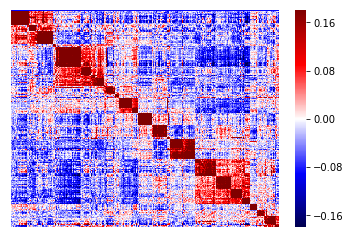

In [11]:
full_dist, full_tree, full_dn = create_clustering(exp_obj.expression_matrix, show=False)
show_correlation_heatmap(exp_obj.expression_matrix, full_dn)

vmax=0.3, vmin=-0.3
(2635, 2635)


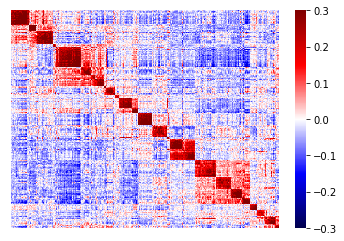

In [8]:
show_correlation_heatmap(exp_obj.expression_matrix, full_dn, vmin=-0.3, vmax=0.3)

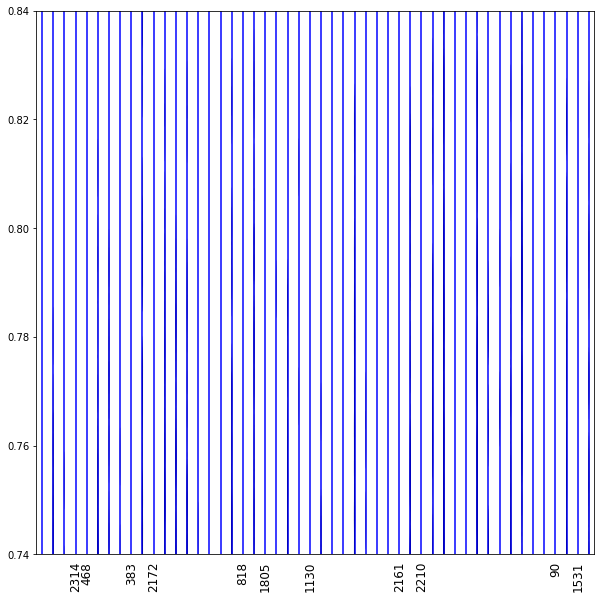

In [9]:
plt.figure(figsize=(10,10))
ax = plt.subplot()
dendrogram(
            full_tree,
            truncate_mode='lastp',  # show only the last p merged clusters
            p=50,  # show only the last p merged clusters
            show_leaf_counts=False,  # otherwise numbers in brackets are counts
            leaf_rotation=90.,
            leaf_font_size=12.,
            show_contracted=True,  # to get a distribution impression in truncated branches,
            ax=ax
        )
ax.set_ylim(bottom=0.74, top=0.84)
plt.show()

# Separate to cell lines

In [10]:
cell_lines_path = BasePaths.CellLineExpression
columns_to_compare=['GE_CCLE_match', 'SNP_CL_match']
cell_id_column="sample_id"

In [11]:
def get_cohesive_cell_lines(csv_path, columns_to_compare, id_column):
    cell_lines = pd.read_csv(csv_path)
    cohesive_cells_lines = cell_lines.loc[
        cell_lines.apply(lambda x: len(np.unique(x[columns_to_compare])) == 1, axis=1)]
    return cohesive_cells_lines[[id_column, columns_to_compare[0]]].rename(
        columns={columns_to_compare[0]: "CellLine"})

In [12]:
cohesive_cell_lines = get_cohesive_cell_lines(cell_lines_path, columns_to_compare, cell_id_column)
cell_lines = set(cohesive_cell_lines['CellLine'].values)
cohesive_cell_lines.groupby('CellLine').count().sort_values(by='sample_id', ascending=False)

sample_id
CellLine                                    
TE14_OESOPHAGUS                          225
8305C_THYROID                            185
OVCAR4_OVARY                             149
ONCODG1_OVARY                            146
CAKI2_KIDNEY                             138
NCIH2228_LUNG                            130
SNU46_UPPER_AERODIGESTIVE_TRACT          125
KALS1_CENTRAL_NERVOUS_SYSTEM             115
SKMEL5_SKIN                              103
U118MG_CENTRAL_NERVOUS_SYSTEM            102
UACC257_SKIN                             100
ASPC1_PANCREAS                            97
SCC25_UPPER_AERODIGESTIVE_TRACT           88
BICR16_UPPER_AERODIGESTIVE_TRACT          87
NCIH2444_LUNG                             79
HUH28_BILIARY_TRACT                       76
OAW28_OVARY                               72
HEC6_ENDOMETRIUM                          65
IM95_STOMACH                              44
HCC366_LUNG                               39
NCIH2073_LUNG                             36
SNU1214_UPPER_AERODIGESTIVE_TRACT         30
TE10_OESOPHAGUS                           26
SU8686_PANCREAS                           17

In [62]:
def get_cohesive_expression_obj(exp_obj, cohesive_cell_lines):
    cohesive_cell_indices = list(map(lambda x: x in cohesive_cell_lines.sample_id.values, exp_obj.cells_matrix))
    cohesive_cell_indices = [c[0] for c in enumerate(cohesive_cell_indices) if c[1]]
    cohesive_exp_matrix = exp_obj.expression_matrix.loc[:, cohesive_cell_indices]
    print(cohesive_exp_matrix.shape, exp_obj.expression_matrix.shape)
    return cohesive_exp_matrix

In [63]:
def change_cells_index_to_barcodes(exp_mat, cell_name):
    exp_mat = exp_mat.transpose()
    exp_mat['barcode'] = list(map(lambda x: cell_name[x], exp_mat.index))
    exp_mat.set_index('barcode', inplace=True)
    return exp_mat

In [64]:
cohesive_exp_matrix = get_cohesive_expression_obj(exp_obj, cohesive_cell_lines)
cohesive_exp_matrix = change_cells_index_to_barcodes(cohesive_exp_matrix, exp_obj.cells_matrix)
cohesive_exp_matrix['CellLine'] = cohesive_cell_lines.set_index('sample_id').loc[cohesive_exp_matrix.index]
cohesive_exp_matrix.head()

(9127, 2274) (9127, 2635)


8        27        33        35        40  \
barcode                                                                
AAACCTGCAAACGTGG-1  1.150069 -0.612891 -0.517273  0.898029 -0.211171   
AAACCTGGTAAATACG-1 -1.617814 -0.612891 -0.517273  1.010792 -1.672097   
AAACCTGGTTAAGTAG-1 -1.617814  1.087895  2.805106 -0.300016  0.123544   
AAACCTGTCAATCTCT-1  0.767870 -0.612891 -0.517273 -0.374173  0.831501   
AAACCTGTCTTATCTG-1 -1.617814 -0.612891 -0.517273 -0.099966 -0.831734   

                          42        43        46        53        54  \
barcode                                                                
AAACCTGCAAACGTGG-1  1.664156  0.214821 -0.645481 -0.251104  1.257913   
AAACCTGGTAAATACG-1 -1.074126 -1.750702  1.174049  0.316563  0.576614   
AAACCTGGTTAAGTAG-1 -1.522396 -0.049915  1.055306  0.500878 -2.022542   
AAACCTGTCAATCTCT-1 -1.969217 -1.750702  1.740204  0.414136  1.218053   
AAACCTGTCTTATCTG-1  0.412197  1.790282  1.226335  0.568649  0.637350   

                                 ...                    32702     32703  \
barcode                          ...                                      
AAACCTGCAAACGTGG-1               ...                 0.222684  1.832808   
AAACCTGGTAAATACG-1               ...                -1.285644 -1.454299   
AAACCTGGTTAAGTAG-1               ...                 0.149358  0.282890   
AAACCTGTCAATCTCT-1               ...                -1.122744 -1.957061   
AAACCTGTCTTATCTG-1               ...                 0.527144  0.357142   

                       32704     32705     32706     32707     32708  \
barcode                                                                
AAACCTGCAAACGTGG-1  1.957944  0.614129  1.232325  2.272645  0.719477   
AAACCTGGTAAATACG-1 -2.951609 -0.985259 -0.027207  0.612259 -0.686145   
AAACCTGGTTAAGTAG-1  0.003024 -0.174310 -0.544563 -0.789441  0.230010   
AAACCTGTCAATCTCT-1 -0.565924 -1.243988 -1.586413 -0.851942 -1.119314   
AAACCTGTCTTATCTG-1  0.886298  0.602200  0.192766  0.676452  1.087158   

                       32717     32721                         CellLine  
barcode                                                                  
AAACCTGCAAACGTGG-1  1.263660 -0.691672  SCC25_UPPER_AERODIGESTIVE_TRACT  
AAACCTGGTAAATACG-1  1.897293 -0.691672    U118MG_CENTRAL_NERVOUS_SYSTEM  
AAACCTGGTTAAGTAG-1 -0.701863 -0.691672                  TE14_OESOPHAGUS  
AAACCTGTCAATCTCT-1 -0.701863 -0.691672    U118MG_CENTRAL_NERVOUS_SYSTEM  
AAACCTGTCTTATCTG-1  1.169953 -0.691672              HUH28_BILIARY_TRACT  

[5 rows x 9128 columns]

In [65]:
cell_lines_dict = {}
for cell_line in set(cohesive_exp_matrix.CellLine.values):
    exp_mat = cohesive_exp_matrix.loc[
        cohesive_exp_matrix.CellLine==cell_line,
        [col for col in cohesive_exp_matrix.columns if col!='CellLine']].transpose()
    if exp_mat.shape[1]>=50:
        cell_lines_dict[cell_line] = exp_mat

## Cluster each cell line

working on TE14_OESOPHAGUS
(225, 225) 25200 (9127, 225) 25200.0


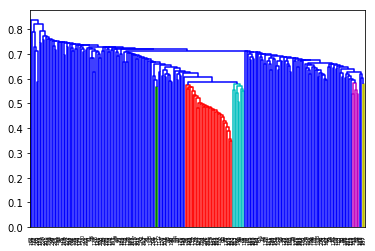

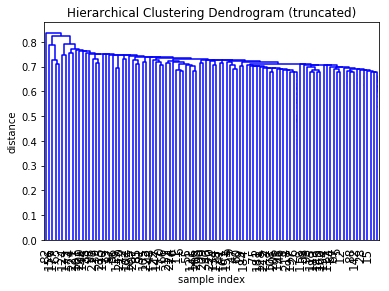

vmax=0.38730654372129103, vmin=0.0
(225, 225)


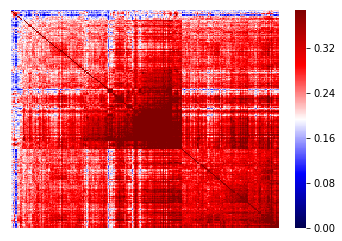

working on BICR16_UPPER_AERODIGESTIVE_TRACT
(87, 87) 3741 (9127, 87) 3741.0


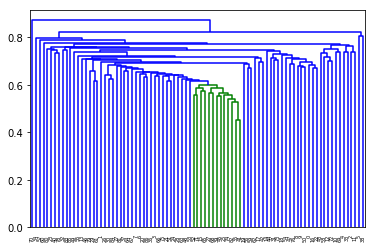

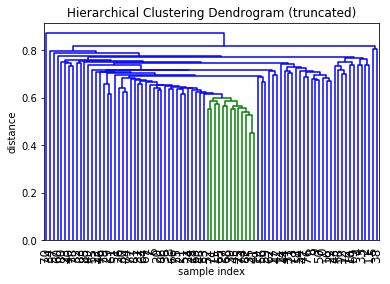

vmax=0.37585450582614643, vmin=0.0
(87, 87)


working on CAKI2_KIDNEY
(138, 138) 9453 (9127, 138) 9453.0


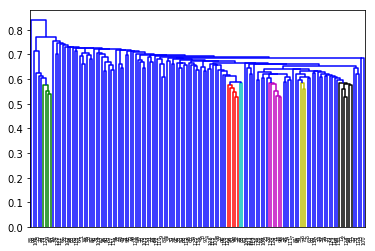

vmax=0.3824699519058153, vmin=0.0
(138, 138)


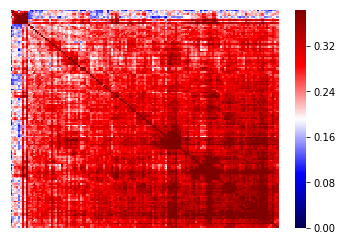

working on 8305C_THYROID
(185, 185) 17020 (9127, 185) 17020.0


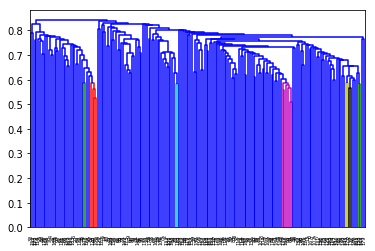

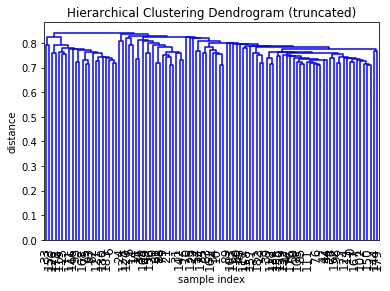

vmax=0.30705181175807705, vmin=0.0
(185, 185)


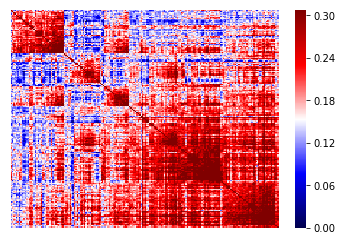

working on NCIH2444_LUNG
(79, 79) 3081 (9127, 79) 3081.0


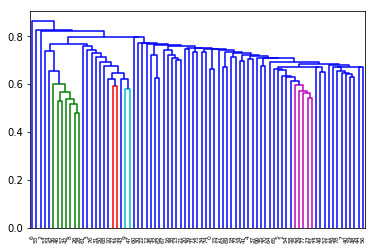

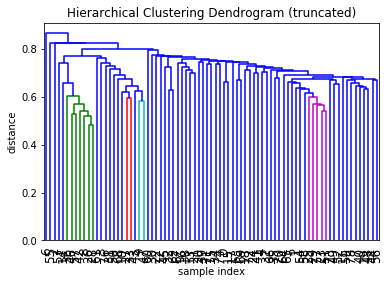

vmax=0.3403977730021431, vmin=0.0
(79, 79)


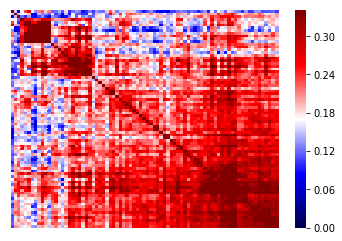

working on SCC25_UPPER_AERODIGESTIVE_TRACT
(88, 88) 3828 (9127, 88) 3828.0


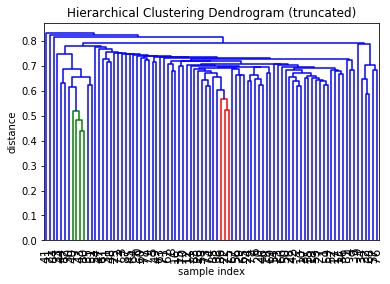

vmax=0.33345660365627217, vmin=0.0
(88, 88)


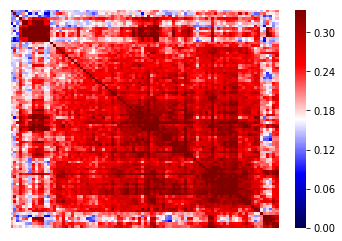

working on U118MG_CENTRAL_NERVOUS_SYSTEM
(102, 102) 5151 (9127, 102) 5151.0


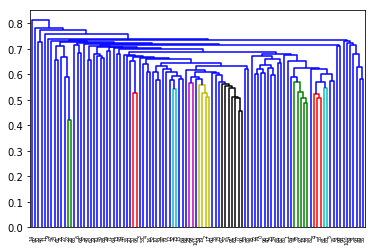

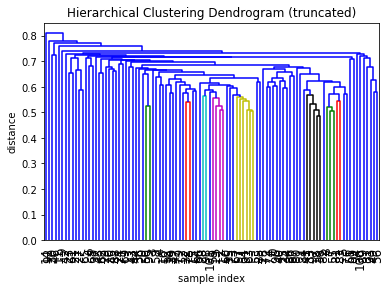

vmax=0.4042459737396351, vmin=0.0
(102, 102)


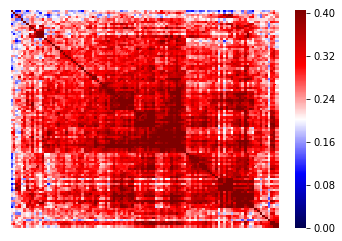

working on ASPC1_PANCREAS
(97, 97) 4656 (9127, 97) 4656.0


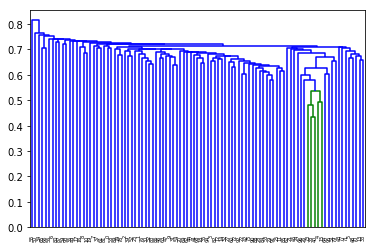

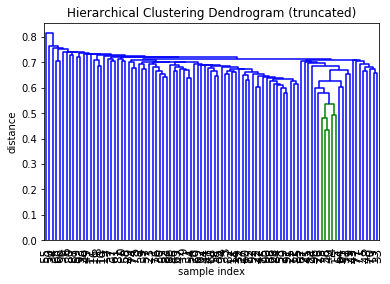

vmax=0.3533771217984693, vmin=0.0
(97, 97)


working on SKMEL5_SKIN
(103, 103) 5253 (9127, 103) 5253.0


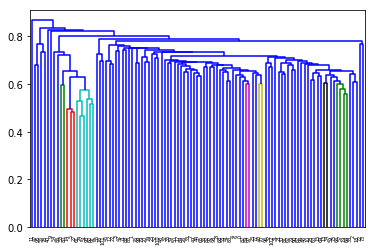

vmax=0.34345050794659016, vmin=0.0
(103, 103)


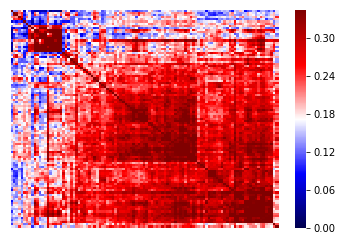

working on HEC6_ENDOMETRIUM
(65, 65) 2080 (9127, 65) 2080.0


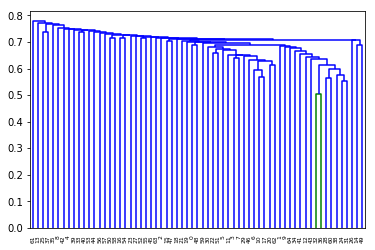

vmax=0.35462728641944397, vmin=0.0
(65, 65)


working on NCIH2228_LUNG
(130, 130) 8385 (9127, 130) 8385.0


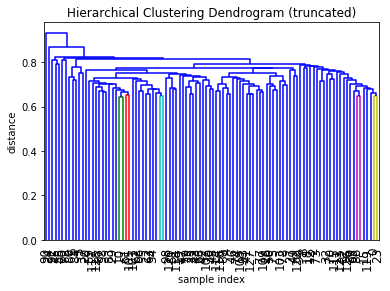

vmax=0.32094640858763995, vmin=0.0
(130, 130)


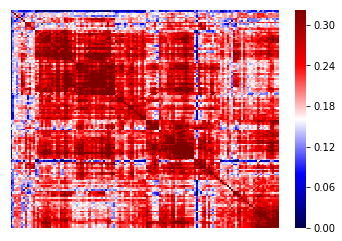

working on HUH28_BILIARY_TRACT
(76, 76) 2850 (9127, 76) 2850.0


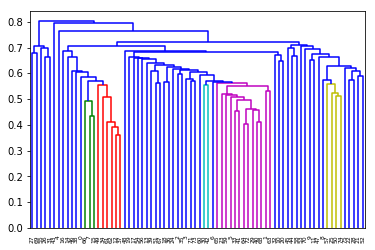

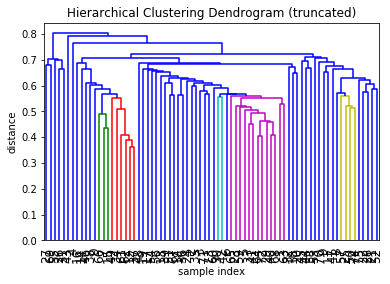

vmax=0.4448768766635951, vmin=0.0
(76, 76)


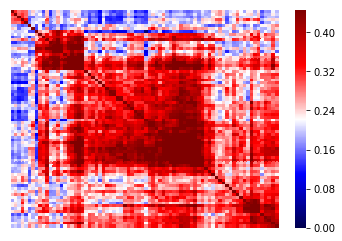

working on ONCODG1_OVARY
(146, 146) 10585 (9127, 146) 10585.0


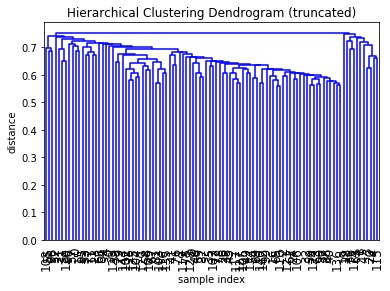

vmax=0.4618959263064763, vmin=0.0
(146, 146)


working on KALS1_CENTRAL_NERVOUS_SYSTEM
(115, 115) 6555 (9127, 115) 6555.0


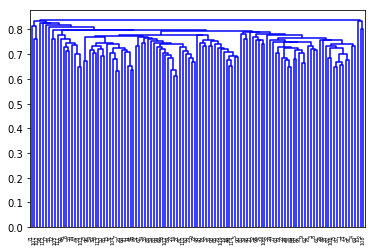

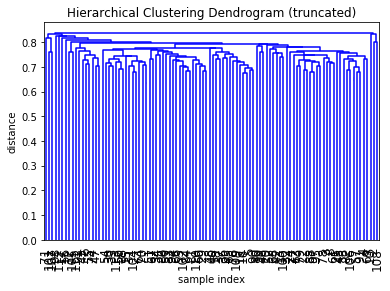

vmax=0.28248388403283864, vmin=0.0
(115, 115)


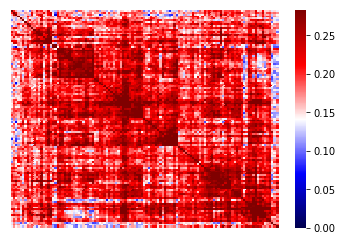

working on OAW28_OVARY
(72, 72) 2556 (9127, 72) 2556.0


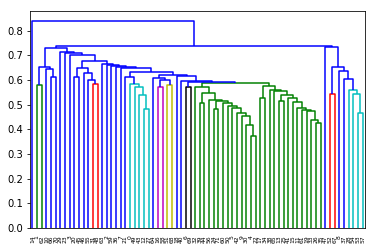

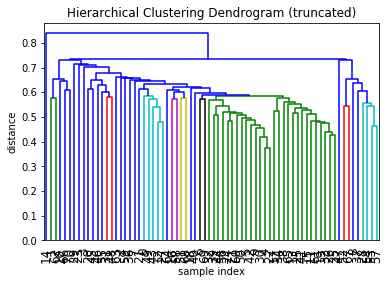

vmax=0.47502753607592807, vmin=0.0
(72, 72)


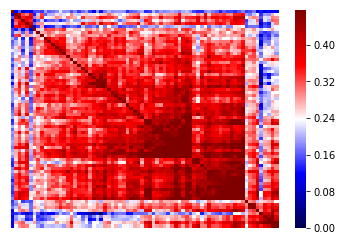

working on OVCAR4_OVARY
(149, 149) 11026 (9127, 149) 11026.0


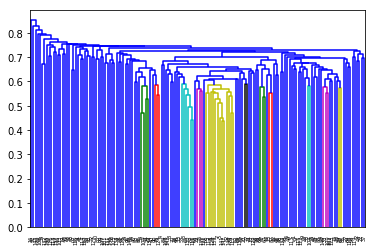

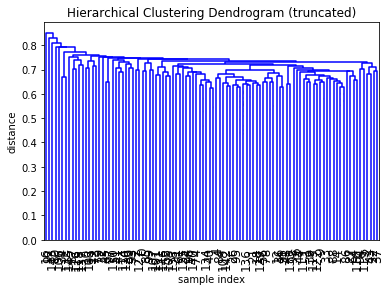

vmax=0.3803426359201004, vmin=0.0
(149, 149)


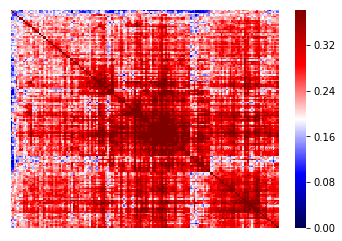

working on UACC257_SKIN
(100, 100) 4950 (9127, 100) 4950.0


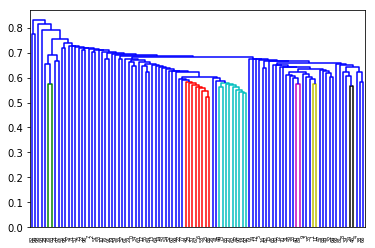

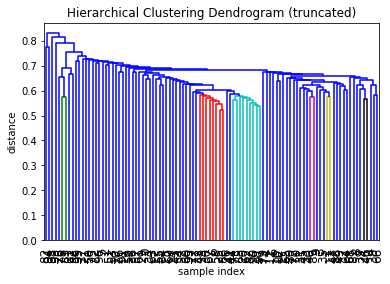

vmax=0.39259193684166654, vmin=0.0
(100, 100)


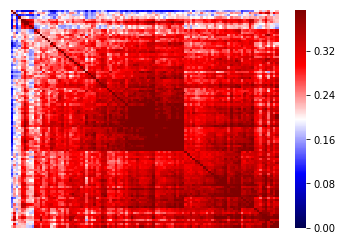

working on SNU46_UPPER_AERODIGESTIVE_TRACT
(125, 125) 7750 (9127, 125) 7750.0


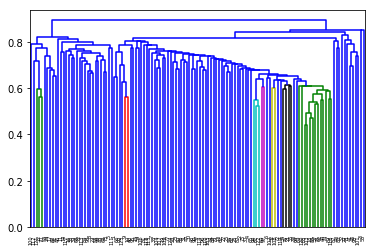

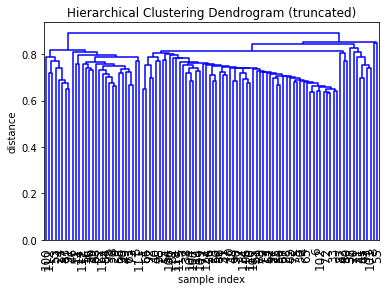

vmax=0.3434643595295079, vmin=0.0
(125, 125)


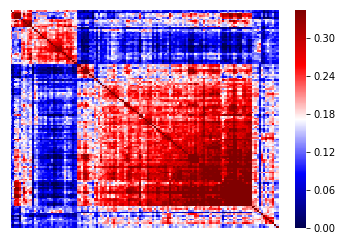

In [66]:
for cell_line, exp_matrix in cell_lines_dict.items():
    print('working on {}'.format(cell_line))
    corr_dist, tree, dn = create_clustering(exp_matrix, show=True)
    show_correlation_heatmap(exp_matrix, dn, vmin=0.0)

## Test new threshold for genes (consider 4)

In [67]:
class HasName: pass
in_path = HasName()
in_path.name = ''
for pipe_step in  exp_obj.composing_items[:2]:
    in_path.name = pipe_step.out_file_path(in_path)
print(in_path.name)
with open(in_path.name, 'rb') as in_file:
    original_exp_obj = pickle.load(in_file)
original_exp_obj

/Users/iriskalka/Dropbox (Weizmann Institute)/CacheCopy/PipelineCache/FromMatExpressionMatrix_NormalizeExpressionByCell


In [68]:
original_exp_obj.expression_matrix = change_cells_index_to_barcodes(
    original_exp_obj.expression_matrix, 
    original_exp_obj.cells_matrix).transpose()
original_exp_obj.expression_matrix.head()

barcode  AAACCTGAGTGGAGTC-1  AAACCTGCAAACGTGG-1  AAACCTGCATTGTGCA-1  \
0                       0.0                 0.0                 0.0   
1                       0.0                 0.0                 0.0   
2                       0.0                 0.0                 0.0   
3                       0.0                 0.0                 0.0   
4                       0.0                 0.0                 0.0   

barcode  AAACCTGGTAAATACG-1  AAACCTGGTTAAGTAG-1  AAACCTGTCAATCTCT-1  \
0                       0.0                 0.0                 0.0   
1                       0.0                 0.0                 0.0   
2                       0.0                 0.0                 0.0   
3                       0.0                 0.0                 0.0   
4                       0.0                 0.0                 0.0   

barcode  AAACCTGTCCAAACTG-1  AAACCTGTCCCTCAGT-1  AAACCTGTCTTATCTG-1  \
0                       0.0            0.000000                 0.0   
1                       0.0            0.000000                 0.0   
2                       0.0            0.000000                 0.0   
3                       0.0           22.715399                 0.0   
4                       0.0            0.000000                 0.0   

barcode  AAACCTGTCTTGCCGT-1         ...          TTTGGTTAGATCCTGT-1  \
0                       0.0         ...                         0.0   
1                       0.0         ...                         0.0   
2                       0.0         ...                         0.0   
3                       0.0         ...                         0.0   
4                       0.0         ...                         0.0   

barcode  TTTGGTTAGCTAACTC-1  TTTGGTTCACTAAGTC-1  TTTGGTTTCTGCTGCT-1  \
0                       0.0                 0.0                 0.0   
1                       0.0                 0.0                 0.0   
2                       0.0                 0.0                 0.0   
3                       0.0                 0.0                 0.0   
4                       0.0                 0.0                 0.0   

barcode  TTTGGTTTCTGGTATG-1  TTTGTCACAAACCCAT-1  TTTGTCACAGATCGGA-1  \
0                       0.0                 0.0                 0.0   
1                       0.0                 0.0                 0.0   
2                       0.0                 0.0                 0.0   
3                       0.0                 0.0                 0.0   
4                       0.0                 0.0                 0.0   

barcode  TTTGTCATCGTCGTTC-1  TTTGTCATCGTTACGA-1  TTTGTCATCTTATCTG-1  
0                       0.0                 0.0                 0.0  
1                       0.0                 0.0                 0.0  
2                       0.0                 0.0                 0.0  
3                       0.0                 0.0                 0.0  
4                       0.0                 0.0                 0.0  

[5 rows x 2736 columns]

working on cell line TE14_OESOPHAGUS


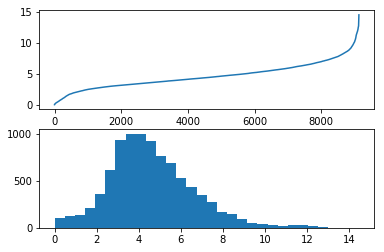

working on cell line BICR16_UPPER_AERODIGESTIVE_TRACT


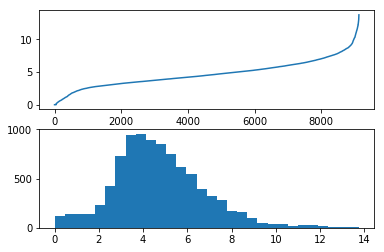

working on cell line CAKI2_KIDNEY


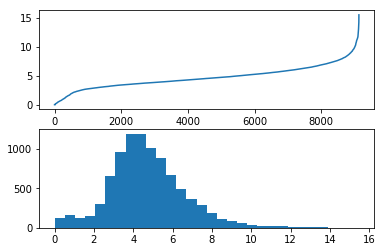

working on cell line 8305C_THYROID


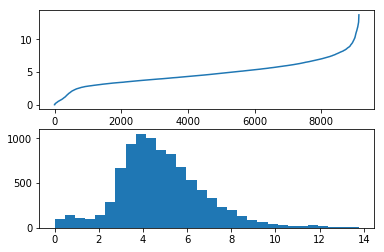

working on cell line NCIH2444_LUNG


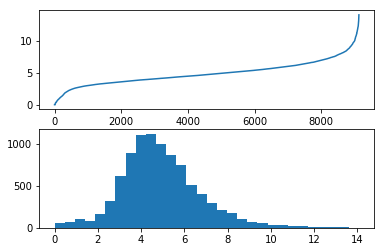

working on cell line SCC25_UPPER_AERODIGESTIVE_TRACT


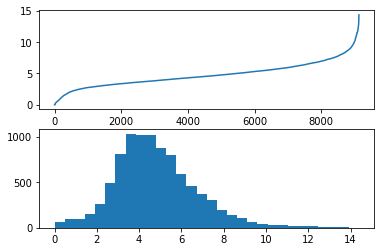

working on cell line U118MG_CENTRAL_NERVOUS_SYSTEM


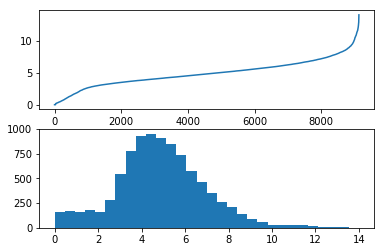

working on cell line ASPC1_PANCREAS


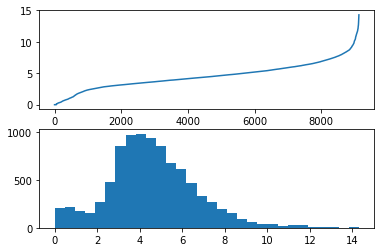

working on cell line SKMEL5_SKIN


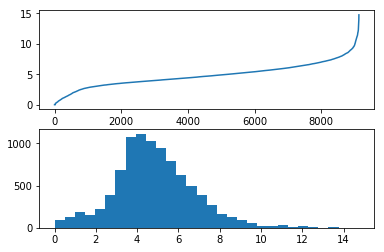

working on cell line HEC6_ENDOMETRIUM


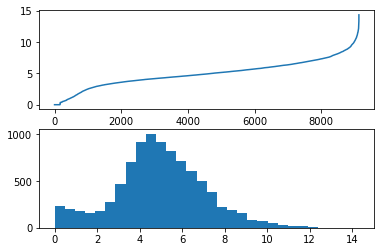

working on cell line NCIH2228_LUNG


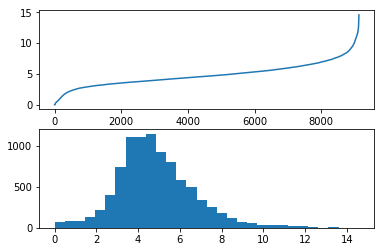

working on cell line HUH28_BILIARY_TRACT


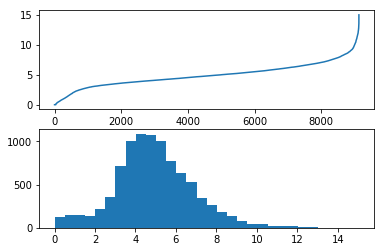

working on cell line ONCODG1_OVARY


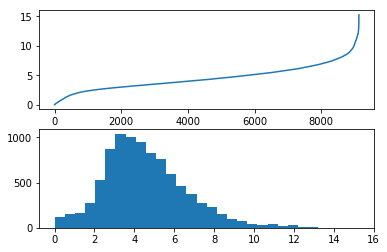

working on cell line KALS1_CENTRAL_NERVOUS_SYSTEM


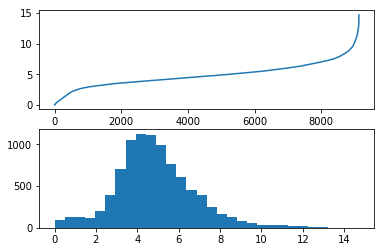

working on cell line OAW28_OVARY


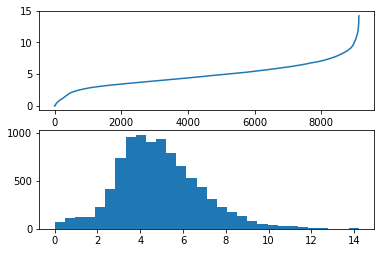

working on cell line OVCAR4_OVARY


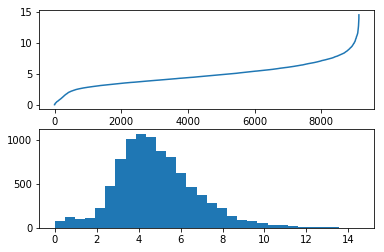

working on cell line UACC257_SKIN


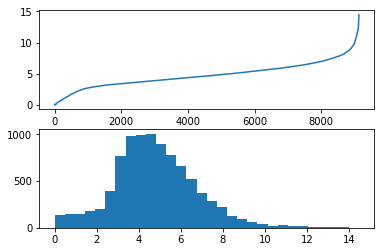

working on cell line SNU46_UPPER_AERODIGESTIVE_TRACT


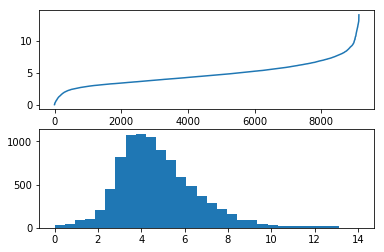

In [69]:
tmp_dict = {}
for cell_line, exp_matrix in cell_lines_dict.items():
    print("working on cell line {}".format(cell_line))
    tmp_original_exp = original_exp_obj.expression_matrix.loc[exp_matrix.index, exp_matrix.columns]
    gene_sum_values = tmp_original_exp.values
    gene_sum_values = gene_sum_values.mean(axis=1)
    gene_sum_values += 1
    gene_sum_values = np.log2(gene_sum_values)
    fig, ax = plt.subplots(2, 1)
    ax[0].plot(range(len(gene_sum_values)), np.sort(gene_sum_values))
    ax[1].hist(gene_sum_values, bins=30)
    plt.show()
    tmp_dict[cell_line] = exp_matrix.iloc[gene_sum_values>4, :]
cell_lines_dict = tmp_dict

In [70]:
cell_line_name = 'ONCODG1_OVARY'
single_cell_line_exp = cell_lines_dict[cell_line_name]
single_cell_line_exp.head()

barcode  AAACGGGCAGGACCCT-1  AAACGGGGTGCGCTTG-1  AAAGCAATCCTTGGTC-1  \
35                 0.966179            0.827275            1.444698   
40                -0.932603           -1.987593           -0.210870   
42                -1.784793           -2.142332           -0.429050   
43                 0.808322            1.310276            1.731083   
46                 1.139670            0.858552            1.320291   

barcode  AAAGTAGTCGGCGCAT-1  AACTCCCAGGTGGGTT-1  AACTCTTGTCCGACGT-1  \
35                 0.829589            0.029701            0.074532   
40                 2.148755           -0.702067           -0.057083   
42                -0.221174            2.253533           -0.316412   
43                 1.636191            0.233739           -1.750702   
46                 1.408857           -0.645481            0.509286   

barcode  AAGACCTAGATGCCAG-1  ACACCCTGTTGGTTTG-1  ACATACGGTGACGGTA-1  \
35                -1.101448            0.518789           -1.013906   
40                 0.417037            1.148604           -0.110808   
42                 0.390324           -1.932444            0.337614   
43                 1.150416            0.341563            0.762365   
46                 2.030721           -0.645481            1.867586   

barcode  ACATCAGGTTGATTCG-1         ...          TGTCCCAAGAACTGTA-1  \
35                 0.435348         ...                    0.314207   
40                 1.893650         ...                    1.828948   
42                -1.359494         ...                   -1.770711   
43                 0.593999         ...                    1.323363   
46                 0.958484         ...                    0.868190   

barcode  TGTCCCACATCATCCC-1  TGTCCCATCAACCATG-1  TTAACTCTCTTGTCAT-1  \
35                 0.473129            0.537795            1.947978   
40                -1.112819            0.980832            1.930923   
42                -1.976564           -1.547123            2.061704   
43                 1.117510            0.904624            0.840673   
46                 1.733326            0.822648           -0.645481   

barcode  TTAGGACCACACATGT-1  TTAGGACCATTACCTT-1  TTAGGCAGTCCAAGTT-1  \
35                 1.196200            0.045039            1.381143   
40                 1.482118            1.695409           -1.482298   
42                -0.497109           -0.638035           -0.585075   
43                -0.992459            0.416993            1.067309   
46                 0.112762            1.159826            0.683915   

barcode  TTCGGTCCAGTATGCT-1  TTGGCAATCGTACGGC-1  TTGTAGGTCTATCCTA-1  
35                 0.601393           -0.392924            0.113426  
40                -0.560711            3.981946           -0.969197  
42                -1.483525           -0.267565           -0.915321  
43                 0.117343            1.104821            0.771727  
46                -0.645481            1.721453            0.195216  

[5 rows x 146 columns]

In [71]:
# Change from log2((TPM/10)+1) to TPM
tpm_data = single_cell_line_exp.copy()
tpm_data = tpm_data.apply(lambda x: 10*((2**x)-1))
tpm_data.head()

barcode  AAACGGGCAGGACCCT-1  AAACGGGGTGCGCTTG-1  AAAGCAATCCTTGGTC-1  \
35                 9.536600            7.743314           17.220575   
40                -4.760876           -7.478407           -1.359840   
42                -7.097823           -7.734867           -2.572493   
43                 7.511732           14.798900           23.197686   
46                12.033054            8.132181           14.971654   

barcode  AAAGTAGTCGGCGCAT-1  AACTCCCAGGTGGGTT-1  AACTCTTGTCCGACGT-1  \
35                 7.771784            0.208008            0.530194   
40                34.344502           -3.853090           -0.387946   
42                -1.421329           37.684908           -1.969354   
43                21.084397            1.758787           -7.028428   
46                16.552677           -3.607202            4.233452   

barcode  AAGACCTAGATGCCAG-1  ACACCCTGTTGGTTTG-1  ACATACGGTGACGGTA-1  \
35                -5.339516            4.327519           -5.047964   
40                 3.351827           12.169928           -0.739307   
42                 3.106873           -7.380151            2.636653   
43                12.197791            2.671287            6.962685   
46                30.860897           -3.607202           26.492136   

barcode  ACATCAGGTTGATTCG-1         ...          TGTCCCAAGAACTGTA-1  \
35                 3.522374         ...                    2.433278   
40                27.157418         ...                   25.527804   
42                -6.102809         ...                   -7.069358   
43                 5.094254         ...                   15.024876   
46                 9.432672         ...                    8.253718   

barcode  TGTCCCACATCATCCC-1  TGTCCCATCAACCATG-1  TTAACTCTCTTGTCAT-1  \
35                 3.881170            4.517516           28.583330   
40                -5.376105            9.736033           28.129897   
42                -7.459057           -6.578083           31.747909   
43                11.697216            8.720565            7.908851   
46                23.249346            7.686497           -3.607202   

barcode  TTAGGACCACACATGT-1  TTAGGACCATTACCTT-1  TTAGGCAGTCCAAGTT-1  \
35                12.913530            0.317111           16.047458   
40                17.935846           22.386874           -6.420816   
42                -2.914750           -3.574126           -3.333854   
43                -4.973796            3.351420           10.955216   
46                 0.812965           12.343053            6.064934   

barcode  TTCGGTCCAGTATGCT-1  TTGGCAATCGTACGGC-1  TTGTAGGTCTATCCTA-1  
35                 5.171811           -2.384155            0.817943  
40                -3.220320          148.010260           -4.892099  
42                -6.423860           -1.692793           -4.697740  
43                 0.847356           11.507215            7.073121  
46                -3.607202           22.976844            1.448952  

[5 rows x 146 columns]

In [72]:
exp_obj.composing_items

In [73]:
tmp_original_exp = original_exp_obj.expression_matrix.loc[single_cell_line_exp.index, single_cell_line_exp.columns]
gene_sum_values = tmp_original_exp.values
gene_sum_values = gene_sum_values.mean(axis=1)
gene_sum_values += 1
gene_sum_values = np.log2(gene_sum_values)
fig, ax = plt.subplots(2, 1)
ax[0].plot(range(len(gene_sum_values)), np.sort(gene_sum_values))
ax[1].hist(gene_sum_values, bins=30)
plt.show()

<font color=red>According to these results we will add create a second threshold of 3</font>

## Recenter genes (and then re-run and save clustering)

In [74]:
centered_cell_lines_dict = {}
for cell_line, cell_line_exp in cell_lines_dict.items():
    centered_cell_lines_dict[cell_line] = {}
    centered_cell_lines_dict[cell_line]['exp_mat'] = cell_line_exp.sub(cell_line_exp.mean(axis=1), axis=0)

working on TE14_OESOPHAGUS, of shape (5327, 225)
(225, 225) 25200 (5327, 225) 25200.0


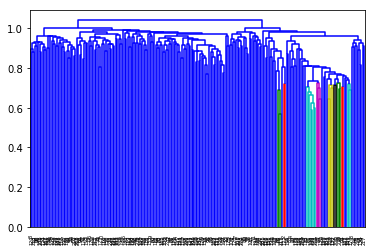

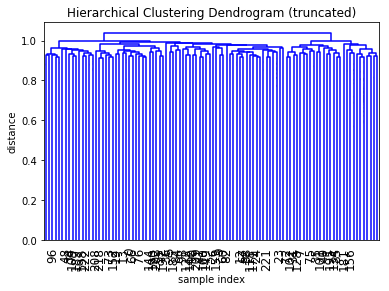

vmax=0.20887820314474934, vmin=-0.20887820314474934
(225, 225)


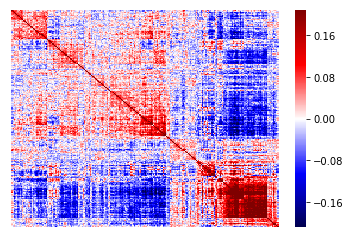

working on BICR16_UPPER_AERODIGESTIVE_TRACT, of shape (5581, 87)
(87, 87) 3741 (5581, 87) 3741.0


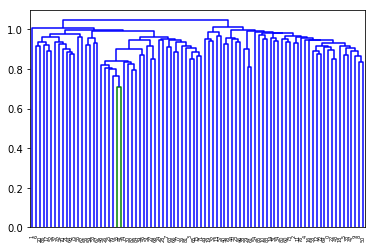

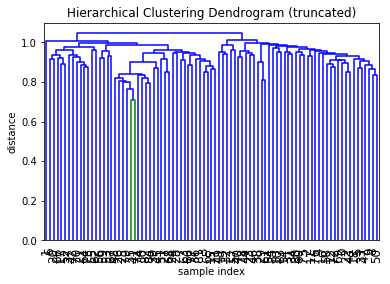

vmax=0.17349120254623268, vmin=-0.17349120254623268
(87, 87)


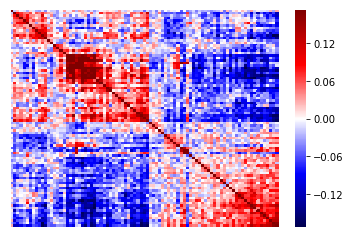

working on CAKI2_KIDNEY, of shape (5724, 138)
(138, 138) 9453 (5724, 138) 9453.0


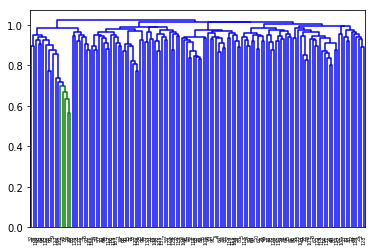

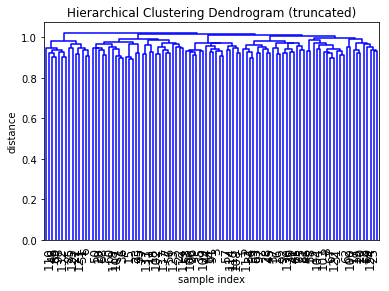

vmax=0.1748980413731182, vmin=-0.1748980413731182
(138, 138)


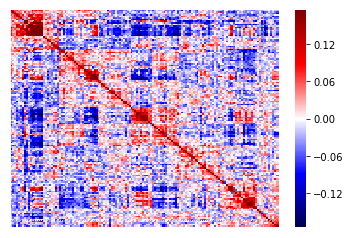

working on 8305C_THYROID, of shape (5843, 185)
(185, 185) 17020 (5843, 185) 17020.0


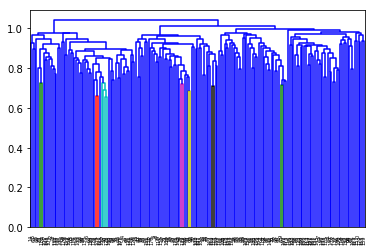

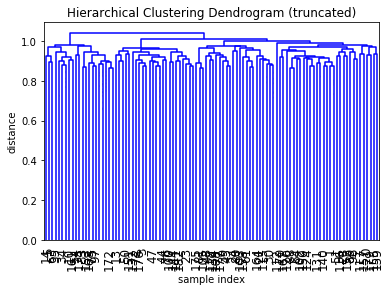

vmax=0.2061412573083114, vmin=-0.2061412573083114
(185, 185)


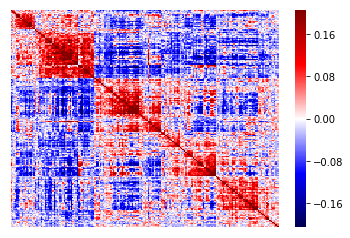

working on NCIH2444_LUNG, of shape (6228, 79)
(79, 79) 3081 (6228, 79) 3081.0


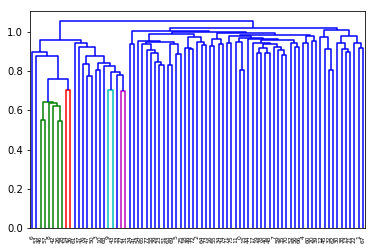

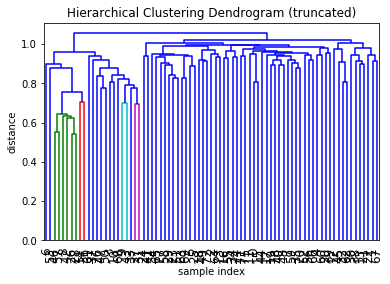

vmax=0.20861554060237805, vmin=-0.20861554060237805
(79, 79)


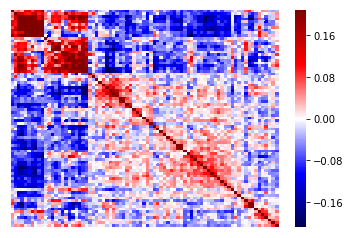

working on SCC25_UPPER_AERODIGESTIVE_TRACT, of shape (5780, 88)
(88, 88) 3828 (5780, 88) 3828.0


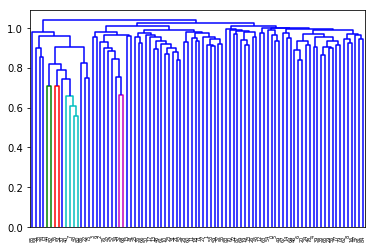

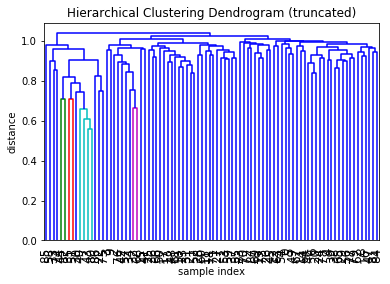

vmax=0.1952111860672239, vmin=-0.1952111860672239
(88, 88)


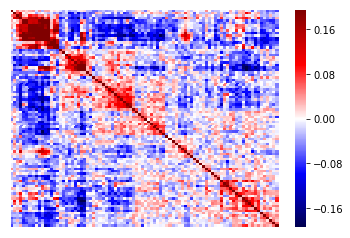

working on U118MG_CENTRAL_NERVOUS_SYSTEM, of shape (6144, 102)
(102, 102) 5151 (6144, 102) 5151.0


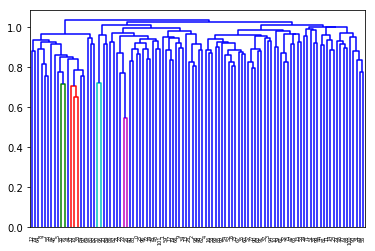

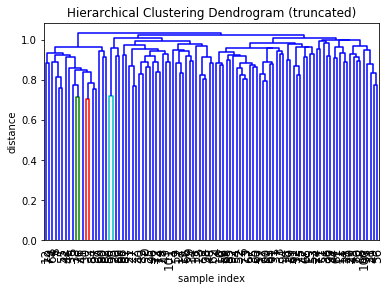

vmax=0.2121178775070976, vmin=-0.2121178775070976
(102, 102)


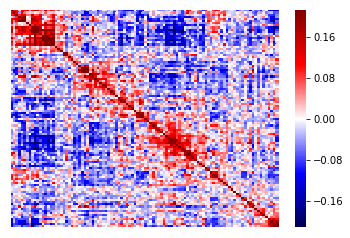

working on ASPC1_PANCREAS, of shape (5432, 97)
(97, 97) 4656 (5432, 97) 4656.0


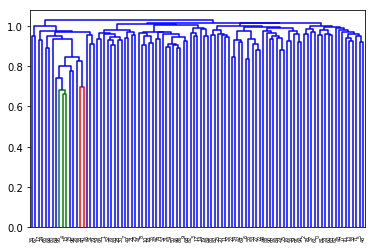

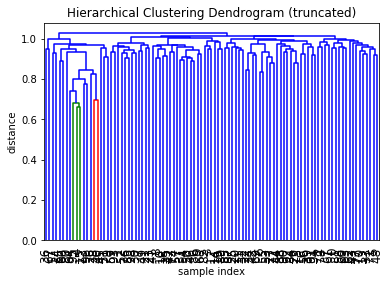

vmax=0.15657522809531704, vmin=-0.15657522809531704
(97, 97)


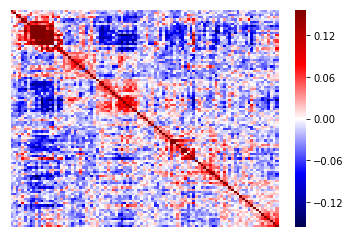

working on SKMEL5_SKIN, of shape (6061, 103)
(103, 103) 5253 (6061, 103) 5253.0


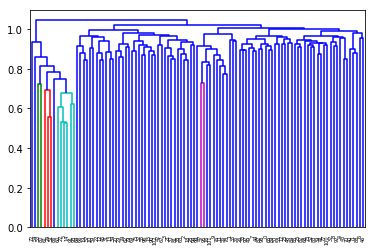

vmax=0.1767281241477743, vmin=-0.1767281241477743
(103, 103)


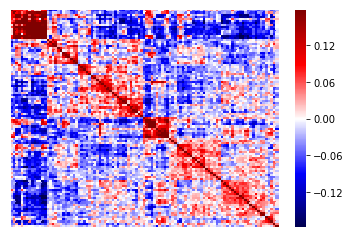

working on HEC6_ENDOMETRIUM, of shape (6443, 65)
(65, 65) 2080 (6443, 65) 2080.0


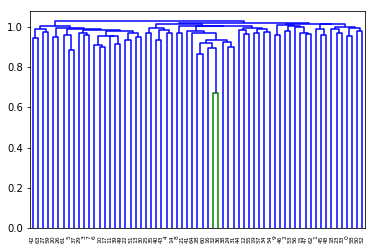

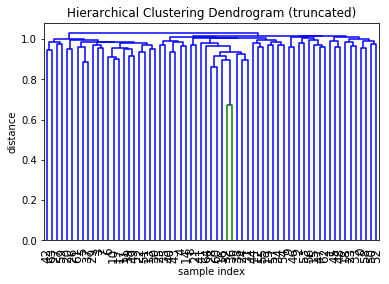

vmax=0.1360107081200351, vmin=-0.1360107081200351
(65, 65)


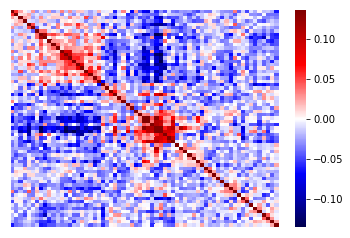

working on NCIH2228_LUNG, of shape (6019, 130)
(130, 130) 8385 (6019, 130) 8385.0


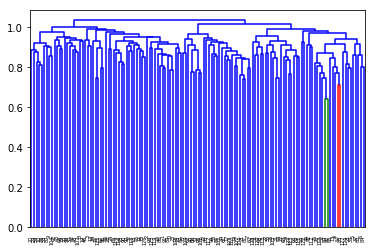

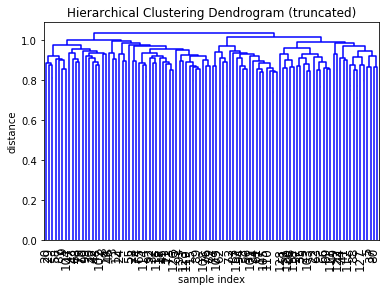

vmax=0.2149746795399129, vmin=-0.2149746795399129
(130, 130)


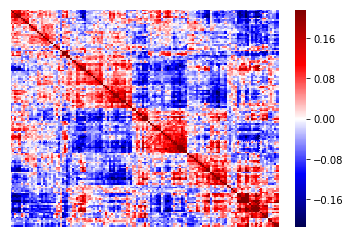

working on HUH28_BILIARY_TRACT, of shape (6317, 76)
(76, 76) 2850 (6317, 76) 2850.0


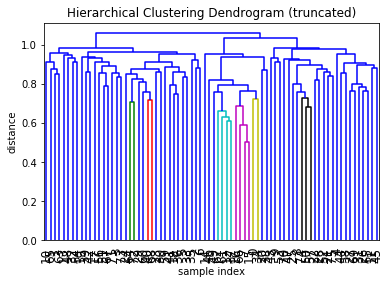

vmax=0.22657137399663158, vmin=-0.22657137399663158
(76, 76)


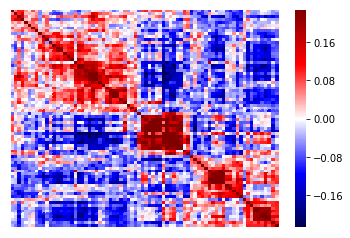

working on ONCODG1_OVARY, of shape (5112, 146)
(146, 146) 10585 (5112, 146) 10585.0


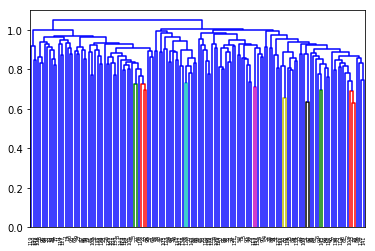

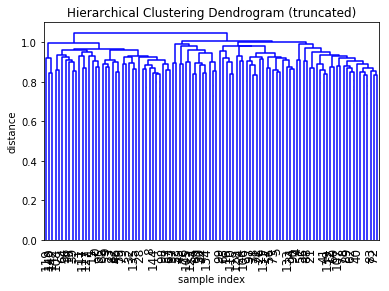

vmax=0.2416775320656548, vmin=-0.2416775320656548
(146, 146)


working on KALS1_CENTRAL_NERVOUS_SYSTEM, of shape (6113, 115)
(115, 115) 6555 (6113, 115) 6555.0


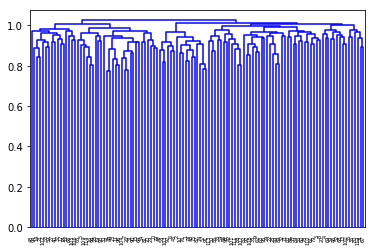

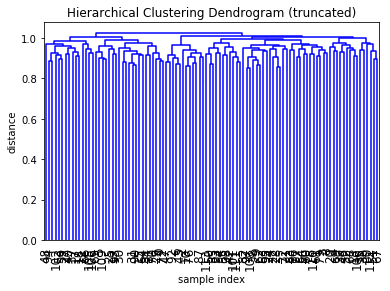

vmax=0.17430244474782539, vmin=-0.17430244474782539
(115, 115)


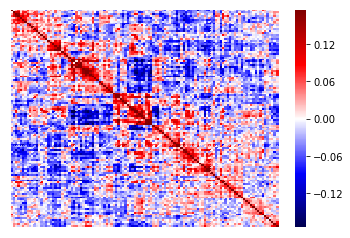

working on OAW28_OVARY, of shape (5928, 72)
(72, 72) 2556 (5928, 72) 2556.0


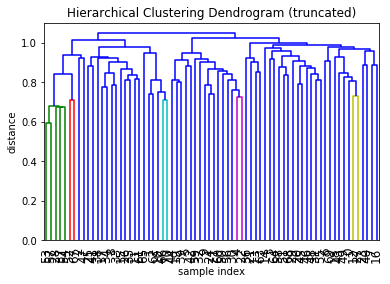

vmax=0.2599233118321043, vmin=-0.2599233118321043
(72, 72)


working on OVCAR4_OVARY, of shape (5937, 149)
(149, 149) 11026 (5937, 149) 11026.0


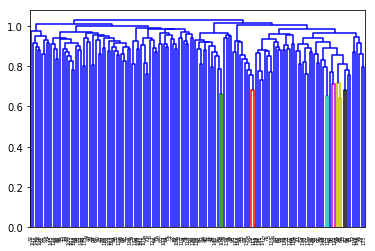

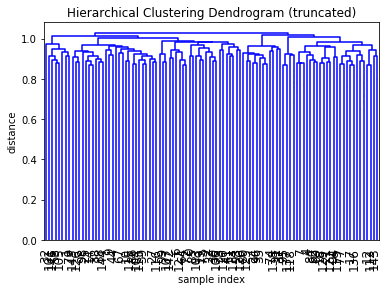

vmax=0.21310183069397215, vmin=-0.21310183069397215
(149, 149)


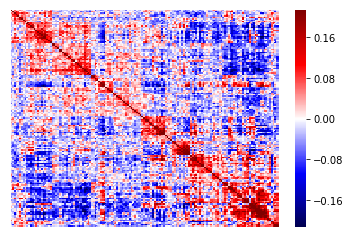

working on UACC257_SKIN, of shape (5901, 100)
(100, 100) 4950 (5901, 100) 4950.0


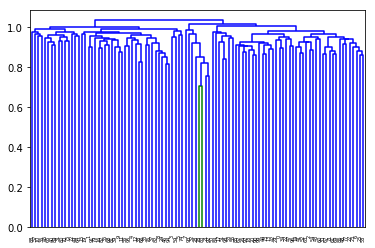

vmax=0.1553973347511733, vmin=-0.1553973347511733
(100, 100)


working on SNU46_UPPER_AERODIGESTIVE_TRACT, of shape (5728, 125)
(125, 125) 7750 (5728, 125) 7750.0


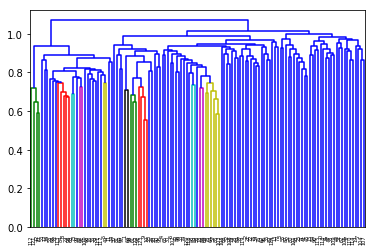

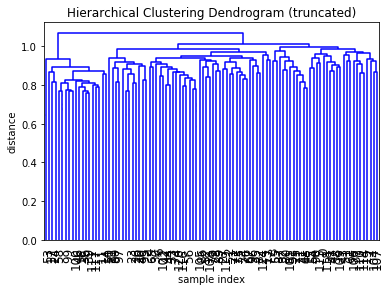

vmax=0.24977081264559245, vmin=-0.24977081264559245
(125, 125)


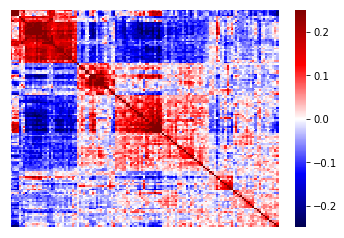

In [75]:
for cell_line, exp_matrix in centered_cell_lines_dict.items():
    print('working on {}, of shape {}'.format(cell_line, exp_matrix['exp_mat'].shape))
    corr_dist, tree, dn = create_clustering(exp_matrix['exp_mat'], show=True)
    centered_cell_lines_dict[cell_line]['corr_dist'] = corr_dist
    centered_cell_lines_dict[cell_line]['tree'] = tree
    centered_cell_lines_dict[cell_line]['dn'] = dn
    show_correlation_heatmap(exp_matrix['exp_mat'], dn)

# Cluster filtering

## Computer differential expression for each cluster in each cell line
For each gene we compute the t_test between cluster and non_cluster cells.
Meaningul clusters are of p-value lower than $10^{-4}$ or $10^{-5}$

In [76]:
def calculate_jaccard_sim_binary(a, b):
    return np.logical_and(a,b).sum() / float(np.logical_or(a, b).sum())

In [86]:
class Tree:
    def __init__(self, linkage_mat, exp_matrix, dend, bottom_threshold=5, top_threshold_percentage=80.0):
        self.linkage_matrix = linkage_mat
        self.exp_matrix = exp_matrix
        self.dn = dend
        self.num_original_elements = self.linkage_matrix.shape[0]+1
        self.children_dict = {}
        self.get_children_dict()
        self.bottom_threshold = bottom_threshold
        self.top_threshold_percentage = top_threshold_percentage
        self.top_threshold = int(math.ceil(self.top_threshold_percentage*self.num_original_elements/100.0))
        print("Using boundaries of {} and {}".format(self.bottom_threshold, self.top_threshold))
        self.filter_clusters_by_size()
    
    def get_children_dict(self):
        for i in range(self.num_original_elements):
            self.children_dict[i] = set([i])
        for i in range(self.linkage_matrix.shape[0]):
            child_1, child_2, _, num_elements = self.linkage_matrix[i]
            try:
                self.children_dict[i+self.num_original_elements] = self.children_dict[
                    int(child_1)].union(self.children_dict[int(child_2)])
                if not len(self.children_dict[i+self.num_original_elements])==num_elements:
                    print("wrong number of elements")
                    raise IOError
            except:
                print("failed at cluster #{}".format(i))
                print(i+1+self.num_original_elements)
                print(child_1)
    
    def filter_clusters_by_size(self):
        self.filtered_clusters = {}
        for clust_id, cluster in self.children_dict.items():
            if len(cluster)>=self.bottom_threshold and len(cluster)<=self.top_threshold:
                self.filtered_clusters[clust_id] = cluster
                
    def create_differential_expression_matrix(self, p_value_threshold=10**-4, fold_change_threshold=2):
        differential_expression_per_cluster = {}
        most_significant_gene_express = pd.DataFrame(
            index=self.exp_matrix.index)
        for clust_id, cluster in self.filtered_clusters.items():
        #     print(clust_id)
            in_clust = centered_cell_lines_dict[cell_line]['exp_mat'].iloc[:, list(cluster)]
            out_clust = centered_cell_lines_dict[cell_line]['exp_mat'].iloc[
                :, list(set(range(
                    centered_cell_lines_dict[cell_line]['exp_mat'].shape[1])) - cluster)]
            diff_exp_genes = pd.DataFrame(data = in_clust.index, columns=['gene_number'])
            diff_exp_genes['ttest_res'] = diff_exp_genes['gene_number'].apply(
                lambda x: scipy.stats.ttest_ind(in_clust.loc[x], out_clust.loc[x]))
            diff_exp_genes['t_statistic'] = diff_exp_genes.ttest_res.apply(lambda x: x[0])
            diff_exp_genes['p_value'] = diff_exp_genes.ttest_res.apply(lambda x: x[1])
            most_significant_gene_express[clust_id] = diff_exp_genes['p_value']
            diff_exp_genes['fold_change'] = diff_exp_genes['gene_number'].apply(
                lambda x: np.absolute(np.mean(in_clust.loc[x]) - np.mean(out_clust.loc[x])))
            diff_exp_genes['is_significant'] = diff_exp_genes.apply(
                lambda x: x['p_value']<=p_value_threshold and x['fold_change']>=fold_change_threshold, axis=1)
#             print("cluster {}, {} differentially expressed genes".format(
#                 clust_id,diff_exp_genes['is_significant'].sum()))
            differential_expression_per_cluster[clust_id] = diff_exp_genes
        self.most_significant_gene_express = most_significant_gene_express
        self.differential_expression_per_cluster = differential_expression_per_cluster
        self.most_significant_cluster_per_gene = self.most_significant_gene_express.apply(
            lambda x: x.idxmin(skipna=True), axis=1).dropna()
        
    def get_significant_clusters(self, min_significant_genes=30, min_most_significant_genes=5, **kwargs):
        if not hasattr(self, 'differential_expression_per_cluster'):
            self.create_differential_expression_matrix(**kwargs)
        significant_clusters = pd.DataFrame(index=['num_significant_genes', 'num_most_significant_genes'])
        for clust_id, cluster in self.filtered_clusters.items():
            try:
                num_significant_genes = self.differential_expression_per_cluster[clust_id]['is_significant'].sum()
            except:
                print('tmp.differential_expression_per_cluster {}, clust_id {}, res'.format(
                    self.differential_expression_per_cluster, clust_id, 
                    self.differential_expression_per_cluster[clust_id]['is_significant'].sum()))
                raise
            num_most_significant_genes = sum(self.most_significant_cluster_per_gene==clust_id)
            if num_significant_genes>=min_significant_genes or \
            num_most_significant_genes>=min_most_significant_genes:
                significant_clusters[clust_id] = [num_significant_genes, num_most_significant_genes]
        print(significant_clusters.shape)
        significant_clusters = significant_clusters.transpose()
        significant_clusters = significant_clusters.reset_index().rename(
            columns={'index':'cluster_id'}).set_index('cluster_id')
        significant_clusters.sort_values(
            by=['num_significant_genes', 'num_most_significant_genes'], 
            inplace=True, ascending=False)
        self.significant_clusters = significant_clusters
        
    def visualize_meaningful_clusters(self, **kwargs):
        if not hasattr(self, 'significant_clusters'):
            self.get_significant_clusters(**kwargs)
        cells_vs_clusters = pd.DataFrame(data = np.array(
            [False]*self.num_original_elements*self.significant_clusters.shape[0]).reshape(
            self.significant_clusters.shape[0], self.num_original_elements),
            index=self.significant_clusters.index, 
            columns=range(self.num_original_elements))
        for cluster_id in self.significant_clusters.index:
            cells_vs_clusters.loc[cluster_id].iloc[list(self.children_dict[cluster_id])] = True
        cells_vs_clusters = cells_vs_clusters.iloc[:, centered_cell_lines_dict[cell_line]['dn']['leaves']]
        cm = matplotlib.colors.LinearSegmentedColormap.from_list('BinaryColormap', ['black', 'yellow'], N=2)
        self.cm = cm
        fig, ax = plt.subplots(2, 1, figsize=(8, 16))

        corr_matrix = np.corrcoef(
            self.exp_matrix.iloc[
                :, self.dn['leaves']].transpose())
        mask = corr_matrix==1
        sns.heatmap(
            corr_matrix, 
            xticklabels=False, 
            yticklabels=False,
            cmap='seismic', 
            vmax=0.3, 
            vmin=-0.3, 
            ax=ax[0])
        print("significant shape matrix {}".format(cells_vs_clusters.shape))
        sns.heatmap(cells_vs_clusters, cmap=cm, ax=ax[1], linewidths=0.01)
        ax[1].set_xlabel('Cells')
        ax[1].get_xaxis().set_ticks(range(cells_vs_clusters.shape[1]))
        ax[1].get_yaxis().set_ticks(range(cells_vs_clusters.shape[0]))
        ax[1].tick_params(labelbottom=False, labelleft=False)
        self.cells_vs_clusters = cells_vs_clusters
        
    def compute_intersection_between_clusters(self, maximal_interaction=0.85):
        intersections_between_clusters = pd.DataFrame(
            index=self.cells_vs_clusters.index, 
            columns=self.cells_vs_clusters.index)
        for row in intersections_between_clusters.index.values:
            for col in intersections_between_clusters.columns.values:
                intersections_between_clusters.loc[row, col] = calculate_jaccard_sim_binary(
                    self.cells_vs_clusters.loc[row], self.cells_vs_clusters.loc[col])
        intersections_between_clusters -= np.identity(intersections_between_clusters.shape[0])
        clusters_to_keep = set(intersections_between_clusters.index)
        print(len(clusters_to_keep))
        while len(np.where(intersections_between_clusters>maximal_interaction)[0])>0:
            clust_1 = intersections_between_clusters.index[np.where(intersections_between_clusters>0.85)[0][0]]
            clust_2 = intersections_between_clusters.index[np.where(intersections_between_clusters>0.85)[1][0]]
            print(clust_1, clust_2)
            if self.significant_clusters.loc[
                clust_1].num_significant_genes > self.significant_clusters.loc[clust_2].num_significant_genes:
                intersections_between_clusters.drop(labels=[clust_2], axis=0, inplace=True)
                intersections_between_clusters.drop(labels=[clust_2], axis=1, inplace=True)
            elif self.significant_clusters.loc[
                clust_1].num_significant_genes < self.significant_clusters.loc[clust_2].num_significant_genes:
                intersections_between_clusters.drop(labels=[clust_1], axis=0, inplace=True)
                intersections_between_clusters.drop(labels=[clust_1], axis=1, inplace=True)
            else:
                if self.significant_clusters.loc[
                    clust_1].num_most_significant_genes > self.significant_clusters.loc[
                    clust_2].num_most_significant_genes:
                    intersections_between_clusters.drop(labels=[clust_2], axis=0, inplace=True)
                    intersections_between_clusters.drop(labels=[clust_2], axis=1, inplace=True)
                else:
                    print("clusters {} and {} are weirdly similar".format(clust_1, clust_2))
                    intersections_between_clusters.drop(labels=[clust_1], axis=0, inplace=True)
                    intersections_between_clusters.drop(labels=[clust_1], axis=1, inplace=True)
        self.intersections_between_clusters = intersections_between_clusters
        fig, ax = plt.subplots(2, 1, figsize=(8, 10))

        corr_matrix = np.corrcoef(
            self.exp_matrix.iloc[
                :, self.dn['leaves']].transpose())
        mask = corr_matrix==1
        sns.heatmap(
            corr_matrix, 
            xticklabels=False, 
            yticklabels=False,
            cmap='seismic', 
            vmax=0.5, 
            vmin=-0.5, 
            ax=ax[0])
        print('intersection shape matrix {}'.format(
            self.cells_vs_clusters.loc[self.intersections_between_clusters.index].shape))
        sns.heatmap(
            self.cells_vs_clusters.loc[self.intersections_between_clusters.index], 
            cmap=self.cm, ax=ax[1], linewidths=0.01)
        ax[1].set_xlabel('Cells')
        ax[1].get_xaxis().set_ticks(range(self.cells_vs_clusters.shape[1]))
        ax[1].get_yaxis().set_ticks(range(self.intersections_between_clusters.shape[0]))
        ax[1].tick_params(labelbottom=False, labelleft=False)

        plt.tight_layout()
        plt.show()

Using boundaries of 5 and 92
(2, 42)
significant shape matrix (42, 115)
42
181 197
213 207
188 171
200 186
intersection shape matrix (38, 115)


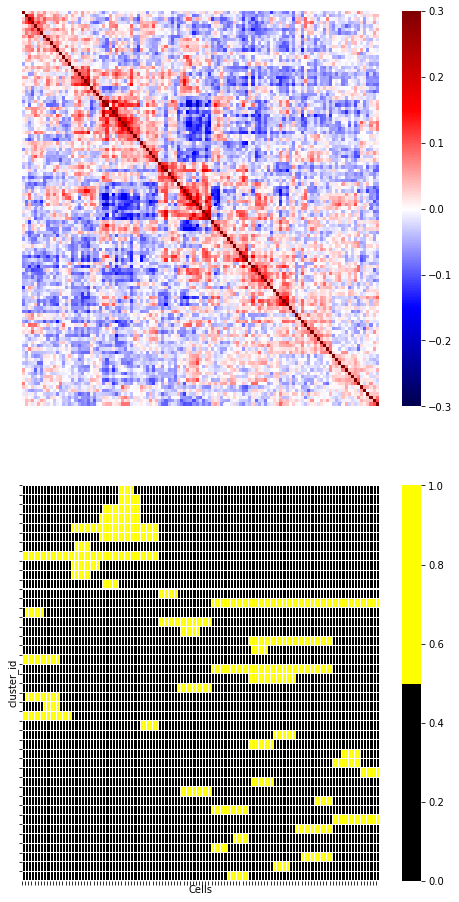

In [303]:
cell_line = 'KALS1_CENTRAL_NERVOUS_SYSTEM'
tmp = Tree(centered_cell_lines_dict[cell_line]['tree'], 
           centered_cell_lines_dict[cell_line]['exp_mat'],
           centered_cell_lines_dict[cell_line]['dn'])
tmp.visualize_meaningful_clusters()
tmp.compute_intersection_between_clusters()

working on cell line TE14_OESOPHAGUS
Using boundaries of 5 and 180
(2, 55)
significant shape matrix (55, 225)
55
318 390
275 265
275 261
275 278
275 266
275 312
275 314
358 380
437 442
440 443
440 444
414 425
clusters 414 and 425 are weirdly similar
intersection shape matrix (43, 225)


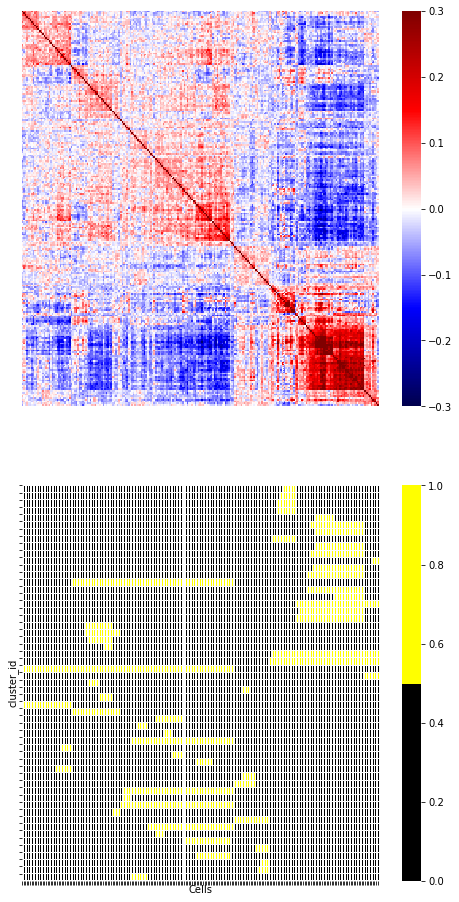

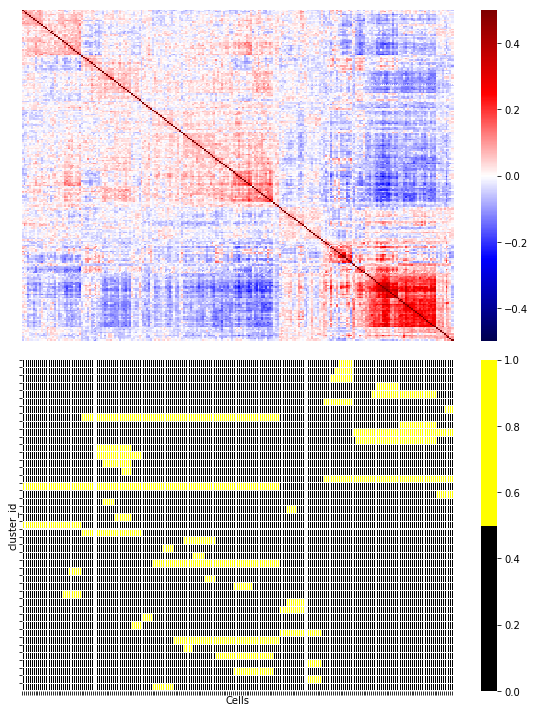

working on cell line BICR16_UPPER_AERODIGESTIVE_TRACT
Using boundaries of 5 and 70
(2, 35)
significant shape matrix (35, 87)
35
125 117
168 170
132 140
132 144
153 156
155 166
169 167
159 162
163 165
intersection shape matrix (26, 87)


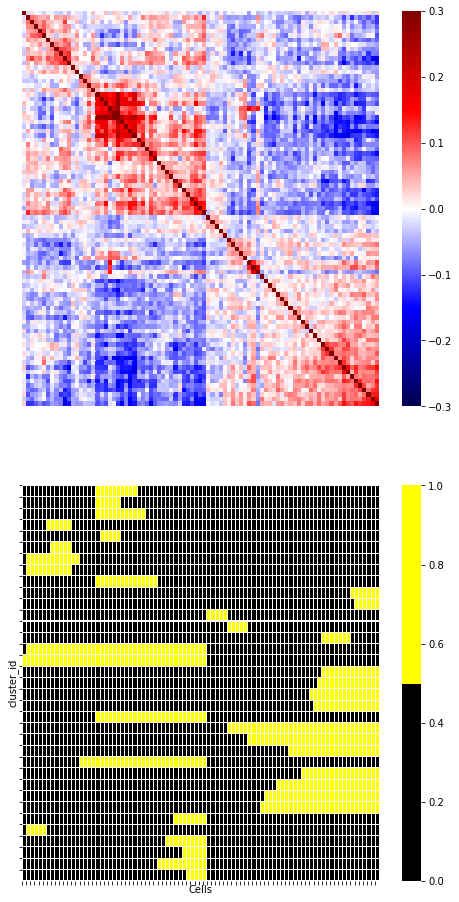

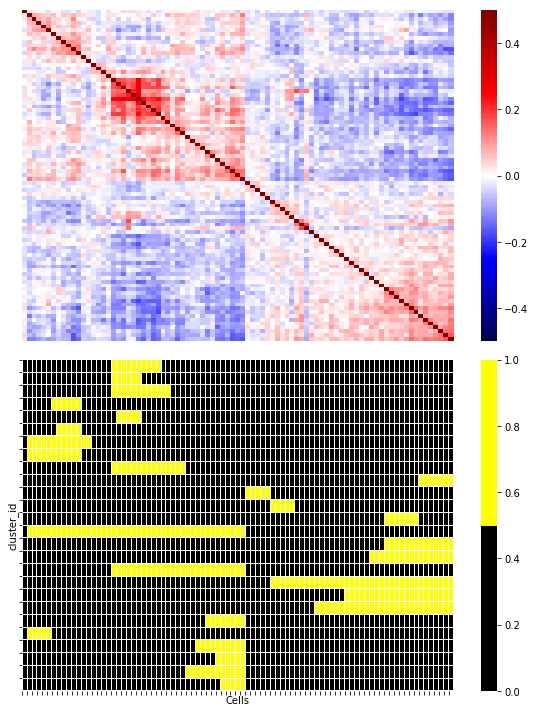

working on cell line CAKI2_KIDNEY
Using boundaries of 5 and 111
(2, 52)
significant shape matrix (52, 138)
52
142 143
166 180
217 236
186 210
160 188
213 203
250 258
246 225
intersection shape matrix (44, 138)


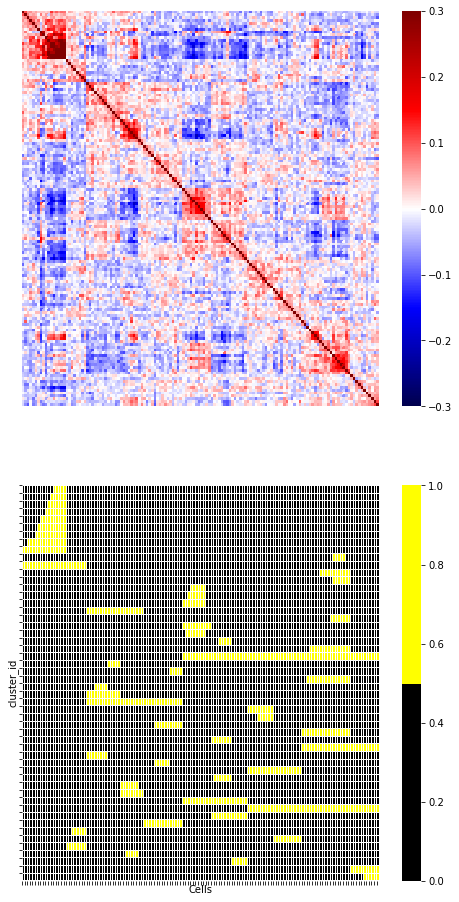

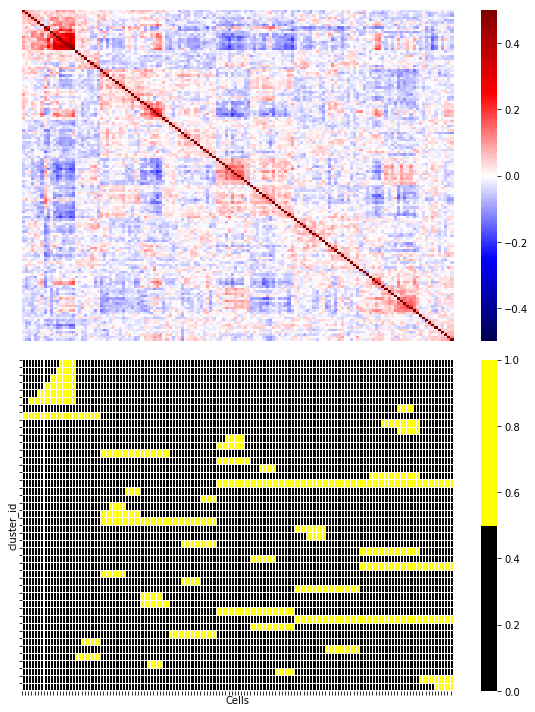

working on cell line 8305C_THYROID
Using boundaries of 5 and 148
(2, 63)
significant shape matrix (63, 185)
63
298 344
298 335
269 284
286 306
283 262
321 343
285 275
349 355
349 359
302 295
302 320
342 331
364 365
364 358
346 350
346 328
intersection shape matrix (47, 185)


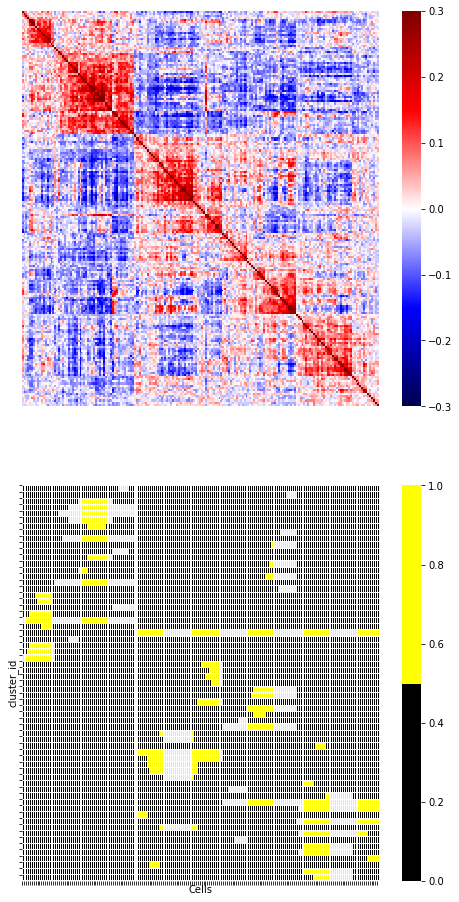

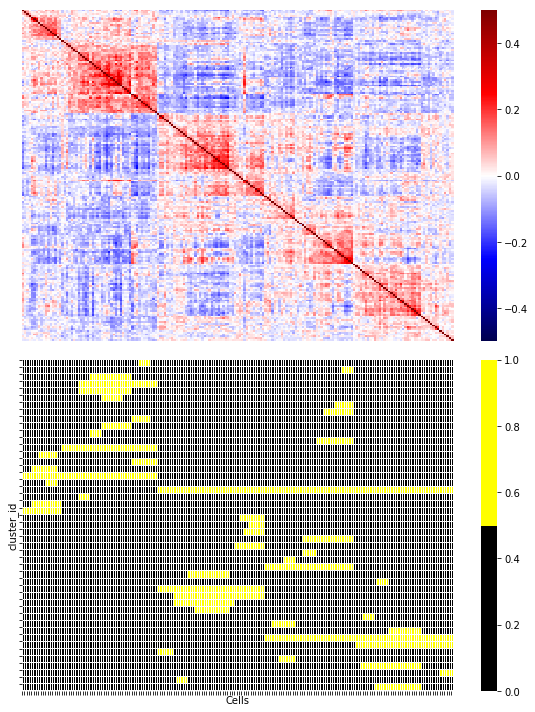

working on cell line NCIH2444_LUNG
Using boundaries of 5 and 64
(2, 30)
significant shape matrix (30, 79)
30
87 101
100 119
146 143
134 137
139 141
153 152
130 124
intersection shape matrix (23, 79)


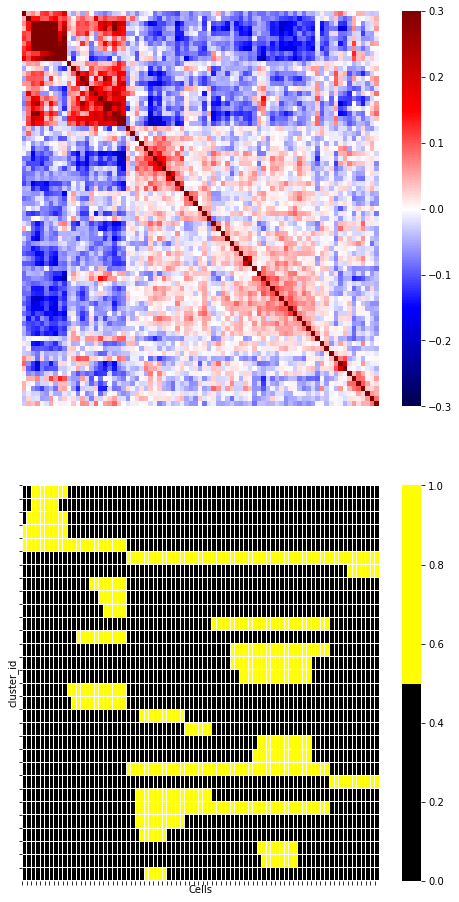

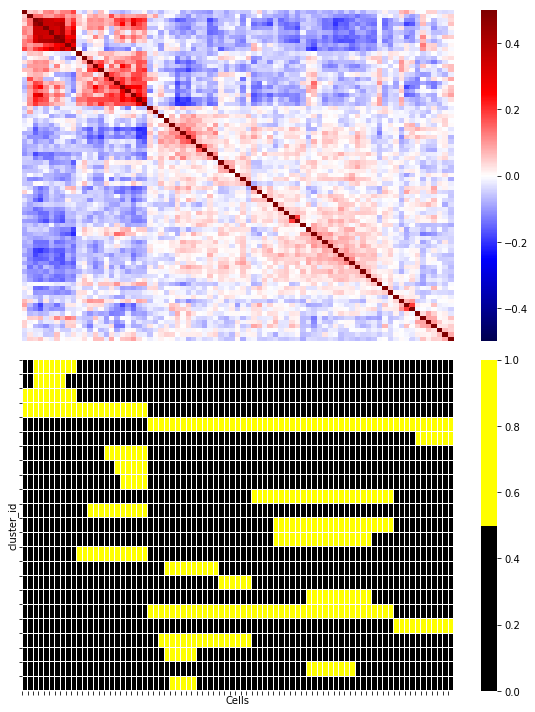

working on cell line SCC25_UPPER_AERODIGESTIVE_TRACT
Using boundaries of 5 and 71
(2, 37)
significant shape matrix (37, 88)
37
110 127
145 160
129 139
163 167
168 165
169 170
intersection shape matrix (31, 88)


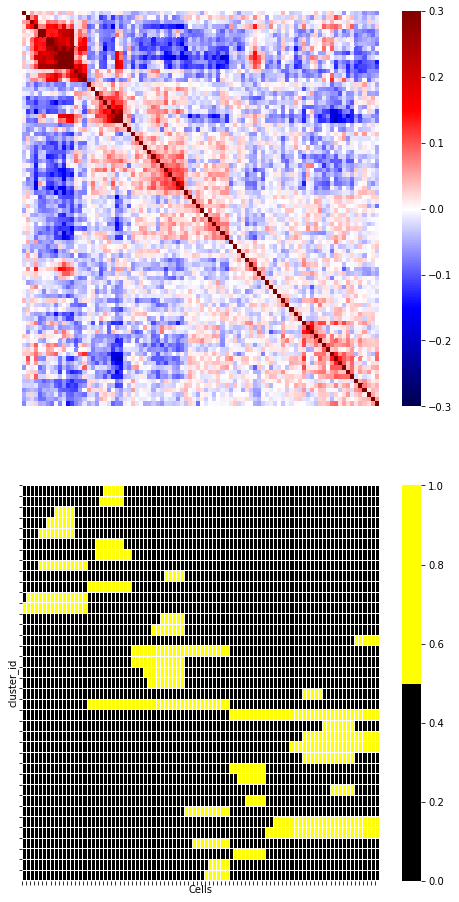

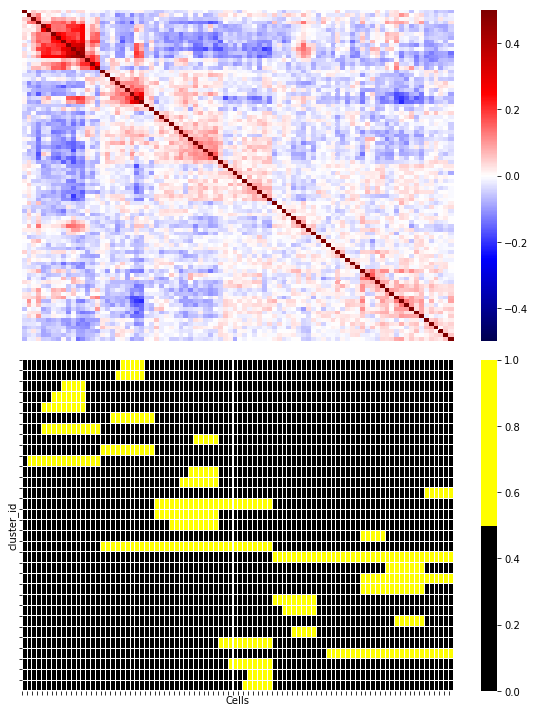

working on cell line U118MG_CENTRAL_NERVOUS_SYSTEM
Using boundaries of 5 and 82
(2, 37)
significant shape matrix (37, 102)
37
126 127
196 199
180 190
171 164
160 141
176 178
intersection shape matrix (31, 102)


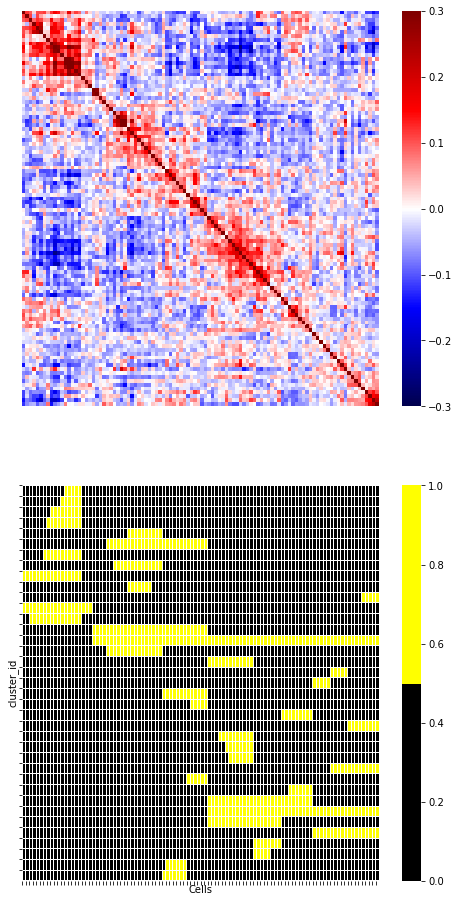

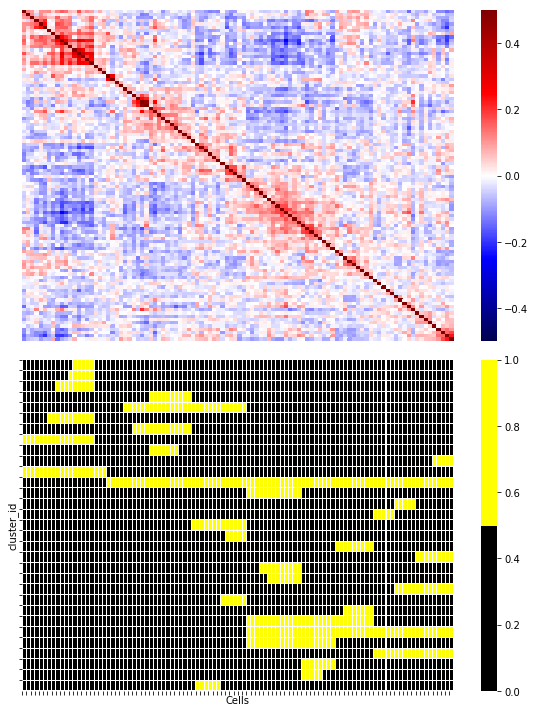

working on cell line ASPC1_PANCREAS
Using boundaries of 5 and 78
(2, 39)
significant shape matrix (39, 97)
39
105 132
170 168
170 185
156 166
154 137
182 176
163 171
intersection shape matrix (32, 97)


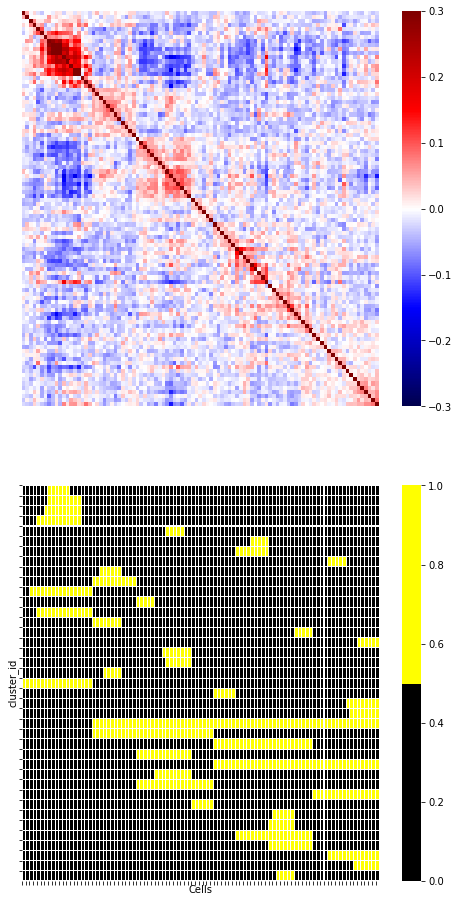

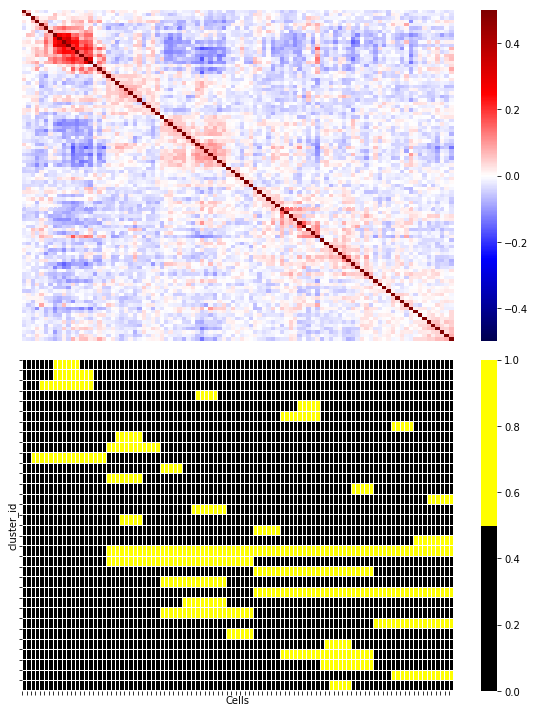

working on cell line SKMEL5_SKIN
Using boundaries of 5 and 83
(2, 37)
significant shape matrix (37, 103)
37
108 112
115 126
115 174
146 157
178 173
intersection shape matrix (32, 103)


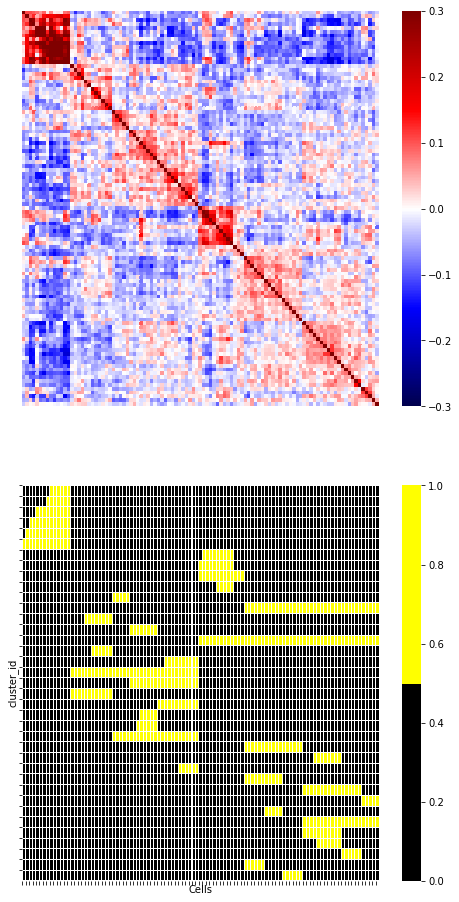

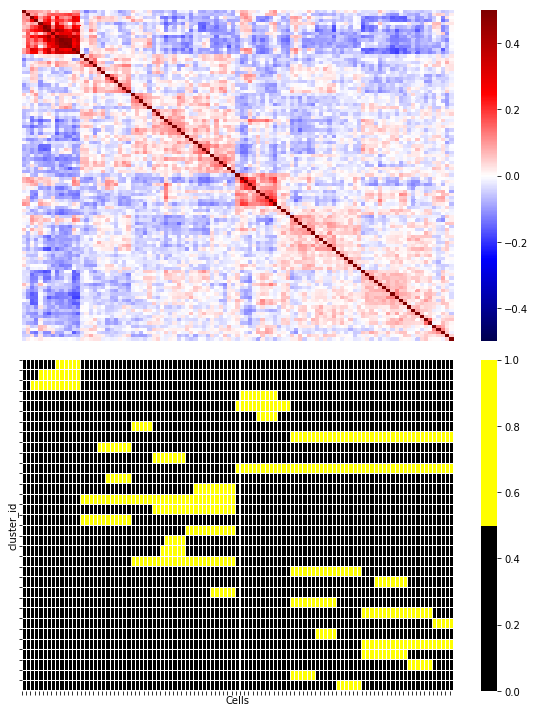

working on cell line HEC6_ENDOMETRIUM
Using boundaries of 5 and 52
(2, 20)
significant shape matrix (20, 65)
20
121 120
116 111
103 92
intersection shape matrix (17, 65)


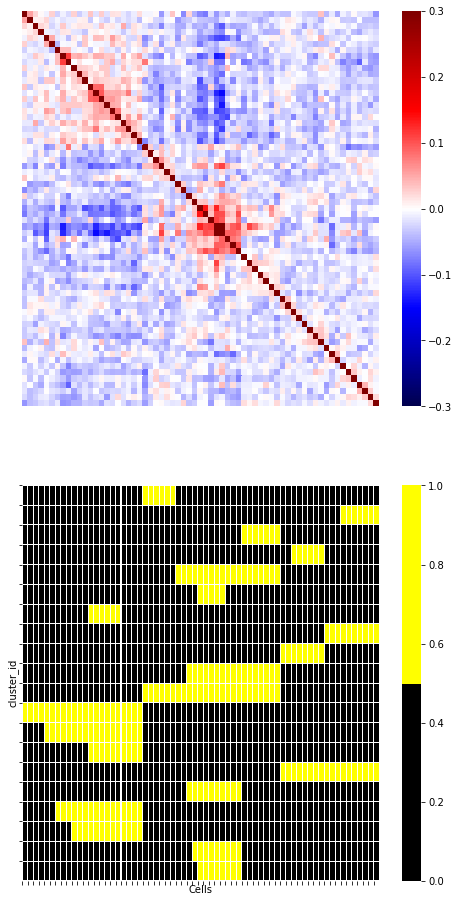

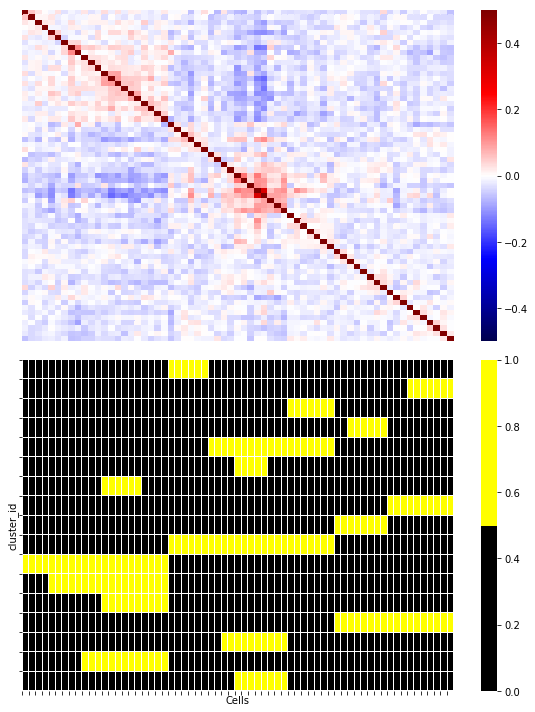

working on cell line NCIH2228_LUNG
Using boundaries of 5 and 104
(2, 54)
significant shape matrix (54, 130)
54
229 237
229 242
224 203
249 240
249 252
173 163
245 247
245 250
227 243
199 180
253 255
241 238
197 219
intersection shape matrix (41, 130)


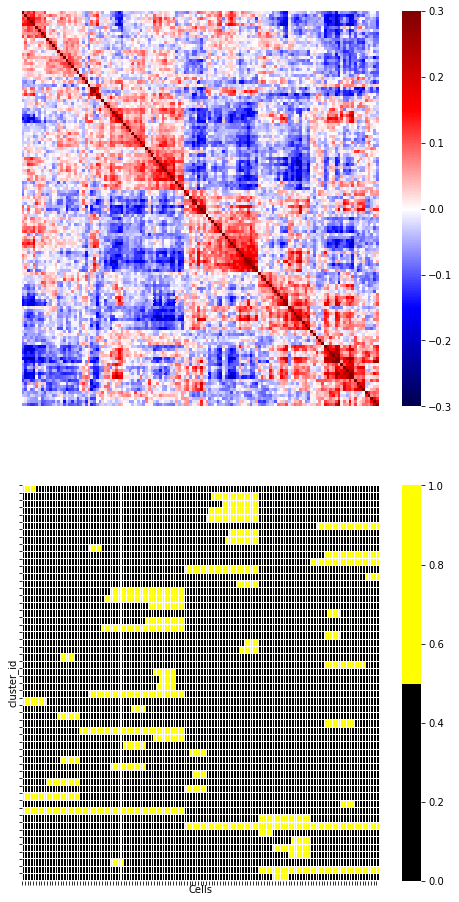

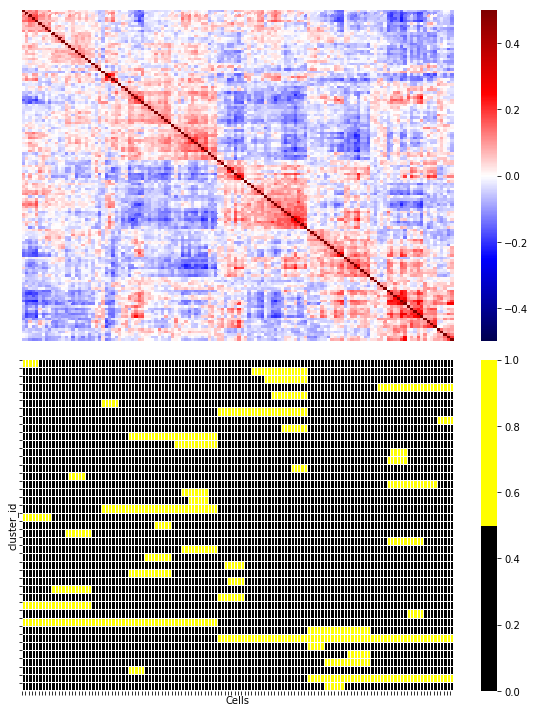

working on cell line HUH28_BILIARY_TRACT
Using boundaries of 5 and 61
(2, 31)
significant shape matrix (31, 76)
31
143 126
96 101
147 146
125 132
139 142
127 123
108 103
135 138
intersection shape matrix (23, 76)


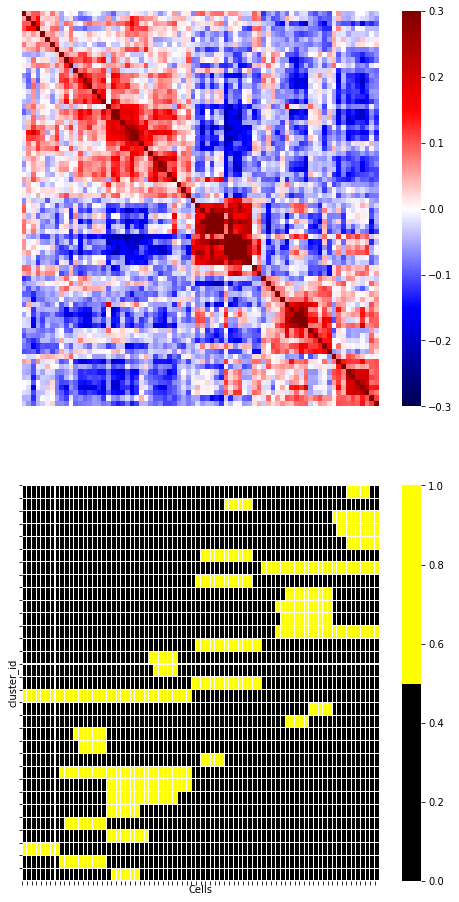

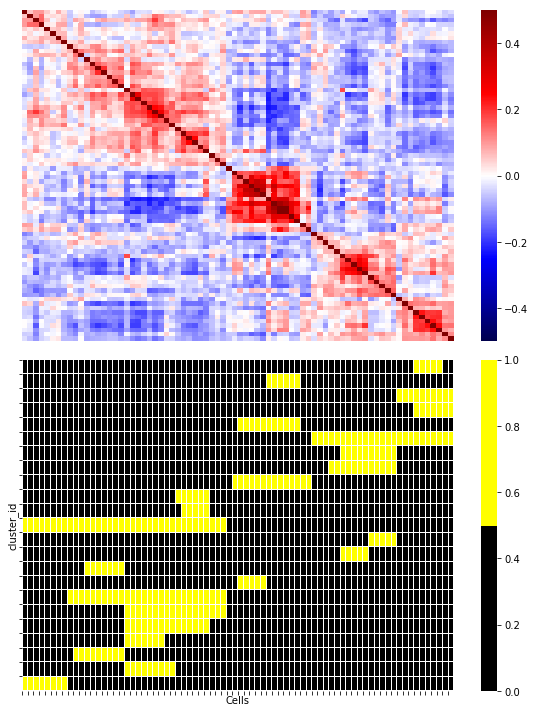

working on cell line ONCODG1_OVARY
Using boundaries of 5 and 117
(2, 49)
significant shape matrix (49, 146)
49
170 188
195 201
250 264
250 228
259 266
259 245
272 279
275 271
275 286
275 281
280 287
273 282
intersection shape matrix (37, 146)


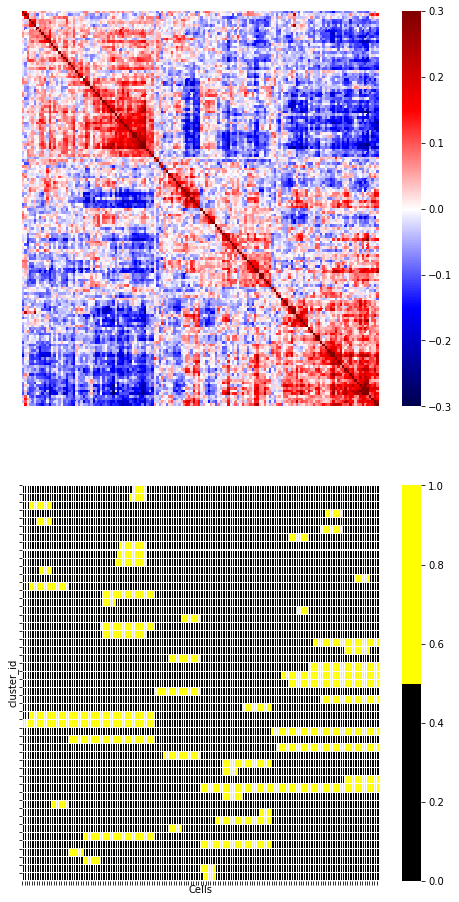

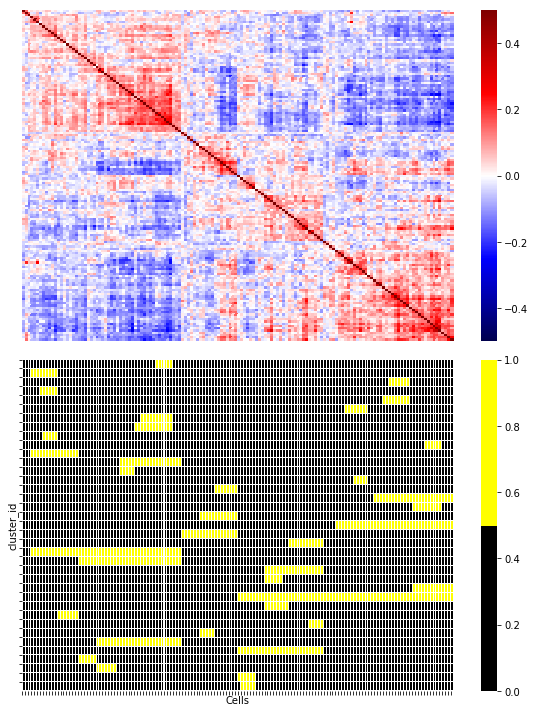

working on cell line KALS1_CENTRAL_NERVOUS_SYSTEM
Using boundaries of 5 and 92
(2, 42)
significant shape matrix (42, 115)
42
181 197
213 207
188 171
200 186
intersection shape matrix (38, 115)


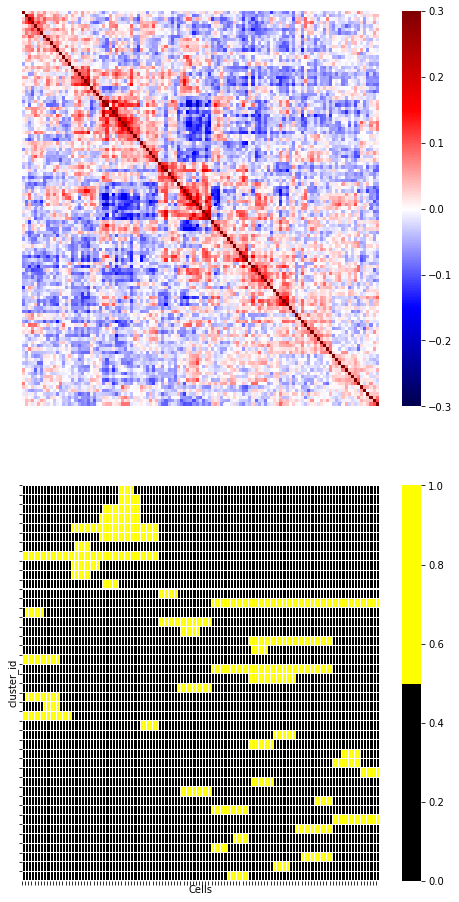

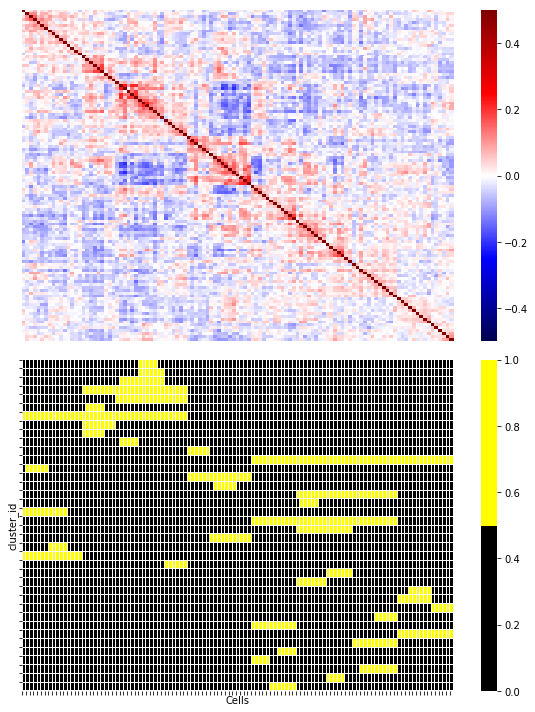

working on cell line OAW28_OVARY
Using boundaries of 5 and 58
(2, 30)
significant shape matrix (30, 72)
30
111 118
107 117
133 135
138 139
clusters 138 and 139 are weirdly similar
115 124
intersection shape matrix (25, 72)


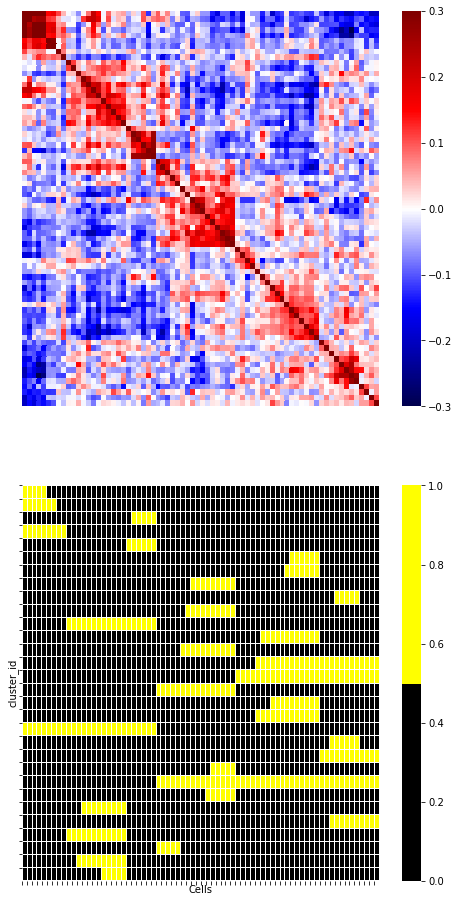

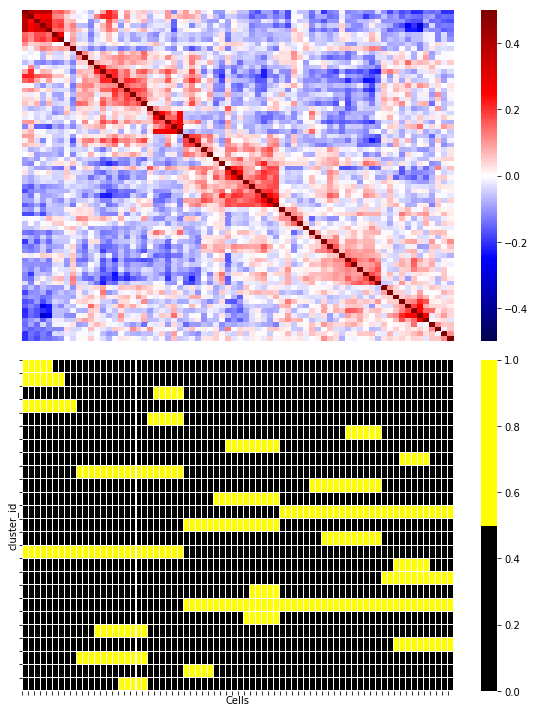

working on cell line OVCAR4_OVARY
Using boundaries of 5 and 120
(2, 49)
significant shape matrix (49, 149)
49
256 251
203 231
287 273
250 189
261 241
291 290
292 294
276 274
intersection shape matrix (41, 149)


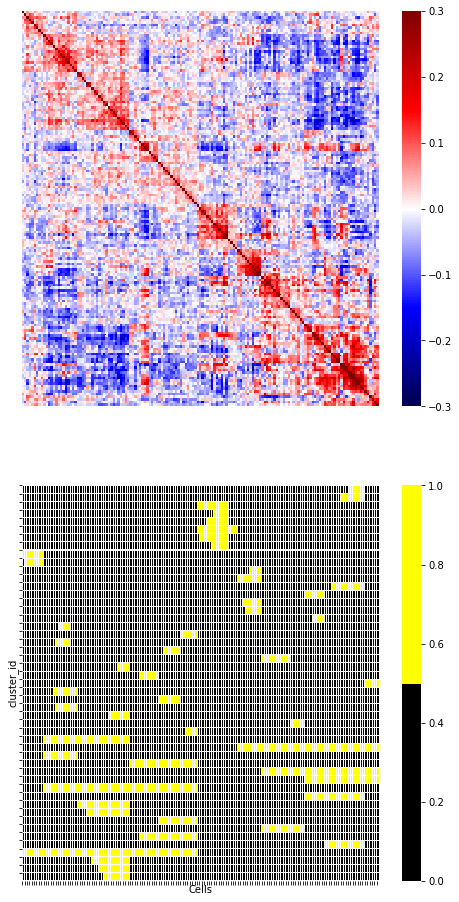

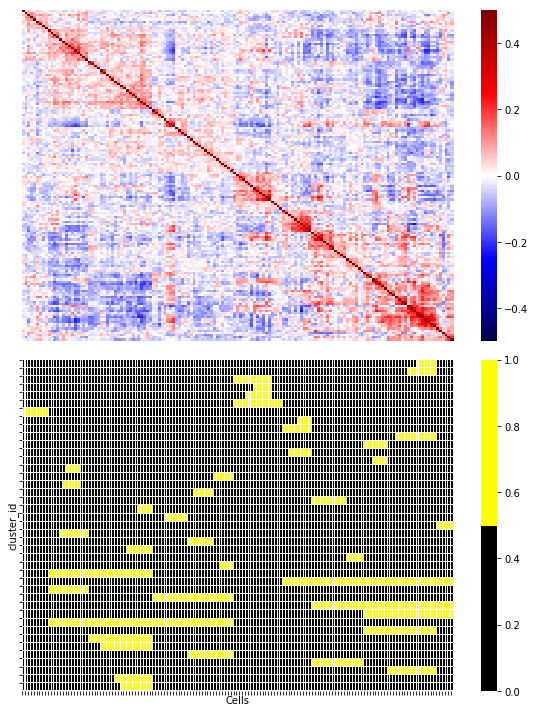

working on cell line UACC257_SKIN
Using boundaries of 5 and 80
(2, 40)
significant shape matrix (40, 100)
40
197 196
189 194
189 184
142 183
138 132
163 158
185 187
156 160
intersection shape matrix (32, 100)


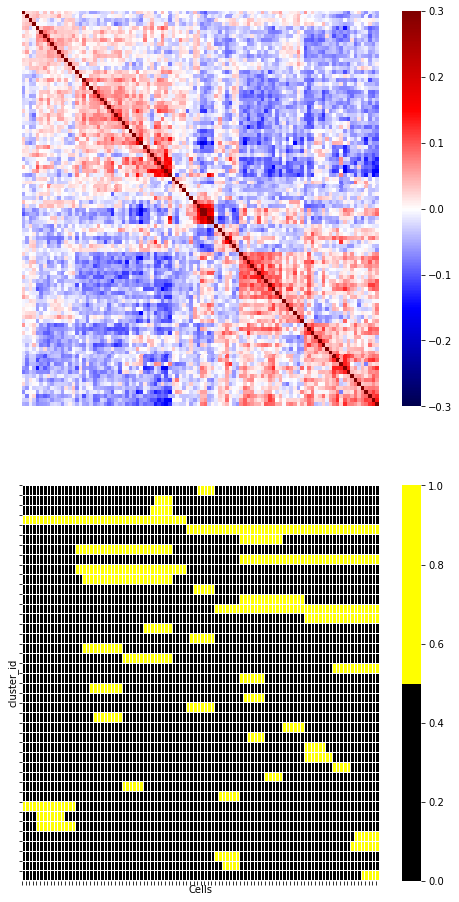

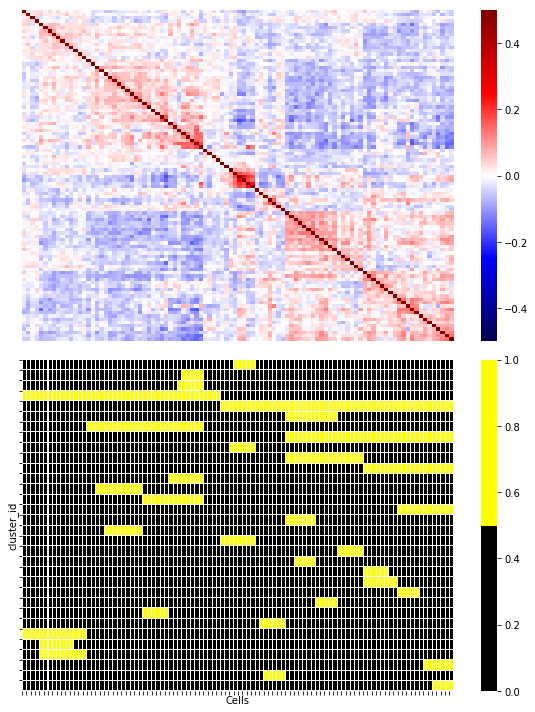

working on cell line SNU46_UPPER_AERODIGESTIVE_TRACT
Using boundaries of 5 and 100
(2, 48)
significant shape matrix (48, 125)
48
151 149
165 169
170 190
228 201
219 234
218 233
clusters 218 and 233 are weirdly similar
156 172
241 235
187 177
187 174
187 188
227 220
212 215
212 204
intersection shape matrix (34, 125)


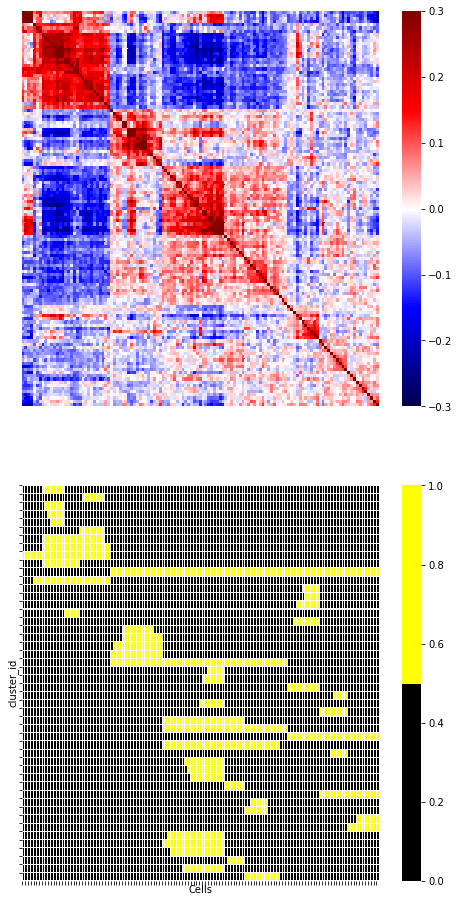

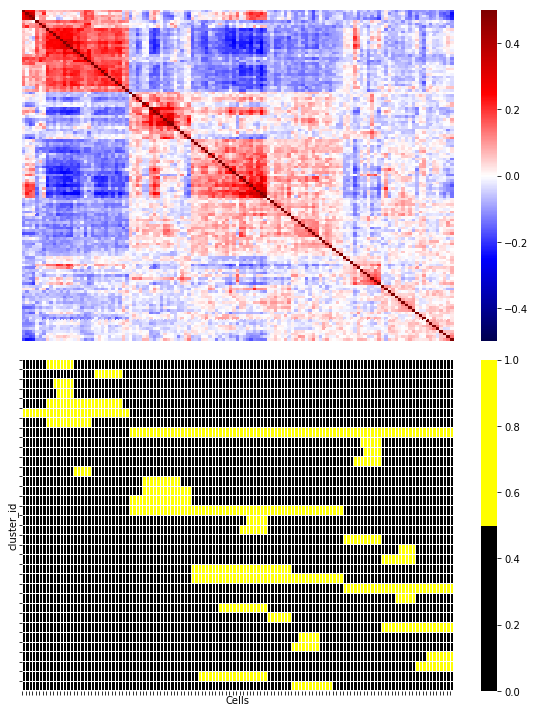

In [87]:
trees_per_cell_line = {}
for cell_line, cell_line_dict in centered_cell_lines_dict.items():
    print("working on cell line {}".format(cell_line))
    ret = Tree(cell_line_dict['tree'], 
               cell_line_dict['exp_mat'],
               cell_line_dict['dn'])
    ret.visualize_meaningful_clusters()
    ret.compute_intersection_between_clusters()
    trees_per_cell_line[cell_line] = ret

<font color=red>sort clusters by score</font>

1. Move from working on single cell line to compare between cell lines. Search programs that repeat between cell lines. Join programs from different cell lines, combine them to metaprograms.
For each program we defined it for a different set of cells. We need to move to differentially expressed genes.
Two options:
1. For each program take the 50 top genes per program that are most significantly differentially expressed. Make sure that most significant genes enter these 50 top genes. If not replace them with the last genes. 
Now we want to compare programs by either jaccard index or size of intersection. 
Add a figure below of from which cell line each program arrived to make sure we do not get clusters by cell lines. 

# From clusters to programs
We are moving our work now from per-cell to per-program (where a program is defined by a cluster).
This requires the following steps:
1. Convert clusters to programs. In order to do this we are going to look at the 50 top differentially expressed genes within a cluster. These will define the program of a cluster. When looking at said 50 top genes, we need to ensure that all most significant genes that are most differentially expressed in the cluster are in the cluster's program. If not then we will add them and remove the genes with the lowest differential expression that are not "most significantly expressed". 
2. We now have all significant clusters from all cell lines, and their programs defined by sets of 50 genes. We now work on defining a distance metric between different programs. To do this we could use the Jaccard index, however, since the size of the union of two programs is at most 100, and decreases when programs are closely related, we are going to use the size of the intersection as the similarity matrix. 
3. Once we have the different programs and their similarity matrix we will cluster them to get a new order of programs. We will show this in a heatmap and below it we will show a heatmp like (use ticks) showing which cell line each program came from. This to ensure we do not end up with clusters that are only based on original cell line of a program.
4. We might want to understand what programs are nearest to our new clusters - thie could be done using http://www.enrichnet.org/ (there is an a web version as well as an API we could try and use).

## Convert clusters to programs

In [183]:
cell_line = 'TE14_OESOPHAGUS'
trees_per_cell_line[cell_line].differential_expression_per_cluster.keys()

dict_keys([231, 232, 238, 246, 248, 249, 250, 252, 253, 254, 257, 259, 261, 265, 266, 275, 278, 281, 286, 288, 290, 299, 302, 303, 304, 305, 312, 314, 317, 318, 338, 344, 346, 349, 353, 358, 364, 368, 369, 373, 374, 377, 378, 379, 380, 382, 386, 388, 389, 390, 391, 393, 394, 395, 396, 398, 401, 404, 405, 406, 407, 408, 409, 411, 412, 413, 414, 416, 418, 419, 420, 421, 422, 423, 425, 426, 428, 429, 430, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447])

In [192]:
cp_diff = trees_per_cell_line[cell_line].differential_expression_per_cluster[231].sort_values(
    by='p_value', 
    ascending=True).copy()
cp_diff['defines_program'] = np.append([True]*50, [False]*(cp_diff.shape[0]-50))
cp_diff = cp_diff.pivot(index='cluster_id', columns='gene_number', values='defines_program')
cp_diff['cluster_id'] = 231

cp_diff2 = trees_per_cell_line[cell_line].differential_expression_per_cluster[246].sort_values(
    by='p_value',
    ascending=True).copy()
cp_diff2['cluster_id'] = 246
cp_diff2['defines_program'] = np.append([True]*50, [False]*(cp_diff2.shape[0]-50))
cp_diff2 = cp_diff2.pivot(index='cluster_id', columns='gene_number', values='defines_program')
cp_diff2['cluster_id'] = 246
pd.merge(cp_diff, cp_diff2, how='outer').set_index('cluster_id')

gene_number  8      33     35     40     42     53     54     57     61     \
cluster_id                                                                   
231          False  False  False  False  False  False  False  False  False   
246          False  False  False  False  False  False  False  False  False   

gene_number  62     ...    32698  32699  32701  32702  32703  32704  32705  \
cluster_id          ...                                                      
231          False  ...    False  False  False  False  False  False  False   
246          False  ...    False  False  False  False  False  False  False   

gene_number  32706  32707  32708  
cluster_id                        
231          False  False  False  
246          False  False  False  

[2 rows x 5327 columns]

Empty DataFrame
Columns: []
Index: []

In [227]:
number_of_genes_per_program = 50
significant_genes_df = []
for cell_line in trees_per_cell_line.keys():
    tmp_dict = []
    for clust_id in trees_per_cell_line[cell_line].differential_expression_per_cluster.keys():
        tmp_df = trees_per_cell_line[cell_line].differential_expression_per_cluster[clust_id].copy()
        tmp_df.sort_values(by='p_value', ascending=True)
        tmp_df['cluster_id'] = clust_id
        tmp_df['defines_program'] = np.append([True]*number_of_genes_per_program, 
                                              [False]*(tmp_df.shape[0]-number_of_genes_per_program))
        tmp_df = tmp_df.pivot(index='cluster_id', columns='gene_number', values='defines_program')
        tmp_df.columns = map(str, tmp_df.columns)
        tmp_df['cluster_id'] = clust_id
        tmp_dict.append(tmp_df)
    tmp_dict = pd.concat(tmp_dict, join='outer', ignore_index=True)
    tmp_dict['cell_line'] = cell_line
    print('cell line {}, tmp_dict shape {}, number of clusters {}'.format(
        cell_line, 
        tmp_dict.shape, 
        len(trees_per_cell_line[cell_line].differential_expression_per_cluster.keys())))
    significant_genes_df.append(tmp_dict)
print('finished working on cell lines')
significant_genes_df = pd.concat(significant_genes_df, join='outer', ignore_index=True)
significant_genes_df.set_index(keys=['cluster_id', 'cell_line'], inplace=True)
significant_genes_df.replace(np.nan, False, inplace=True)
print(significant_genes_df.shape)
significant_genes_df.head()

cell line TE14_OESOPHAGUS, tmp_dict shape (95, 5329), number of clusters 95
cell line BICR16_UPPER_AERODIGESTIVE_TRACT, tmp_dict shape (36, 5583), number of clusters 36
cell line CAKI2_KIDNEY, tmp_dict shape (55, 5726), number of clusters 55
cell line 8305C_THYROID, tmp_dict shape (80, 5845), number of clusters 80
cell line NCIH2444_LUNG, tmp_dict shape (30, 6230), number of clusters 30
cell line SCC25_UPPER_AERODIGESTIVE_TRACT, tmp_dict shape (37, 5782), number of clusters 37
cell line U118MG_CENTRAL_NERVOUS_SYSTEM, tmp_dict shape (37, 6146), number of clusters 37
cell line ASPC1_PANCREAS, tmp_dict shape (39, 5434), number of clusters 39
cell line SKMEL5_SKIN, tmp_dict shape (37, 6063), number of clusters 37
cell line HEC6_ENDOMETRIUM, tmp_dict shape (21, 6445), number of clusters 21
cell line NCIH2228_LUNG, tmp_dict shape (54, 6021), number of clusters 54
cell line HUH28_BILIARY_TRACT, tmp_dict shape (32, 6319), number of clusters 32
cell line ONCODG1_OVARY, tmp_dict shape (59, 5114)

1000  10003  10008   1002  10022  10025  10034  \
cluster_id cell_line                                                          
231        TE14_OESOPHAGUS  False  False  False  False  False  False  False   
232        TE14_OESOPHAGUS  False  False  False  False  False  False  False   
238        TE14_OESOPHAGUS  False  False  False  False  False  False  False   
246        TE14_OESOPHAGUS  False  False  False  False  False  False  False   
248        TE14_OESOPHAGUS  False  False  False  False  False  False  False   

                            10038  10039  10040  ...     9978   9979    998  \
cluster_id cell_line                             ...                          
231        TE14_OESOPHAGUS  False  False  False  ...    False  False  False   
232        TE14_OESOPHAGUS  False  False  False  ...    False  False  False   
238        TE14_OESOPHAGUS  False  False  False  ...    False  False  False   
246        TE14_OESOPHAGUS  False  False  False  ...    False  False  False   
248        TE14_OESOPHAGUS  False  False  False  ...    False  False  False   

                             9986   9988   9991   9992   9995   9996   9997  
cluster_id cell_line                                                         
231        TE14_OESOPHAGUS  False  False  False  False  False  False  False  
232        TE14_OESOPHAGUS  False  False  False  False  False  False  False  
238        TE14_OESOPHAGUS  False  False  False  False  False  False  False  
246        TE14_OESOPHAGUS  False  False  False  False  False  False  False  
248        TE14_OESOPHAGUS  False  False  False  False  False  False  False  

[5 rows x 8887 columns]

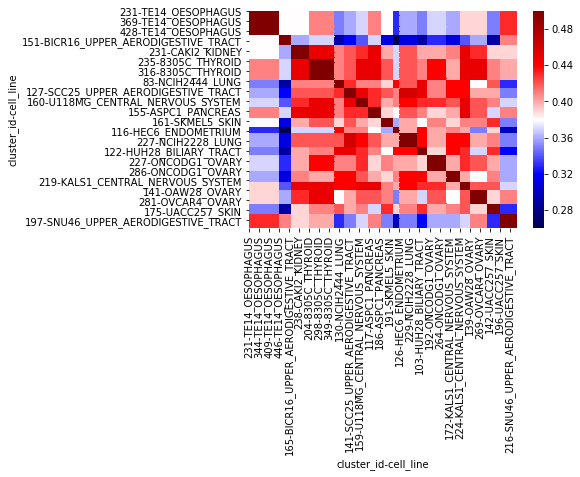

In [297]:
program_distmat = significant_genes_df.apply(
    lambda x: significant_genes_df.apply(
        lambda y:sum(np.logical_and(x, y))/100, axis=1), axis=1)
sns.heatmap(program_distmat, cmap='seismic')

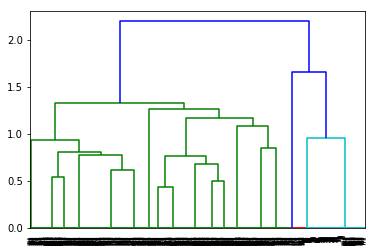

In [298]:
program_corr_tree = linkage(program_distmat, method='average')
program_dn = dendrogram(program_corr_tree)
program_distmat_sorted = program_distmat.iloc[program_dn['leaves'], program_dn['leaves']]

In [299]:
original_cell_line = pd.DataFrame(columns=list(program_distmat_sorted.index.get_level_values(1).unique().sort_values()), 
             index=program_distmat_sorted.columns,
             data=np.array(list(map(lambda x: np.array(list(
                 program_distmat_sorted.index.get_level_values(1).unique().sort_values()))==x,
                                    program_distmat_sorted.columns.get_level_values(1).values)))).transpose()

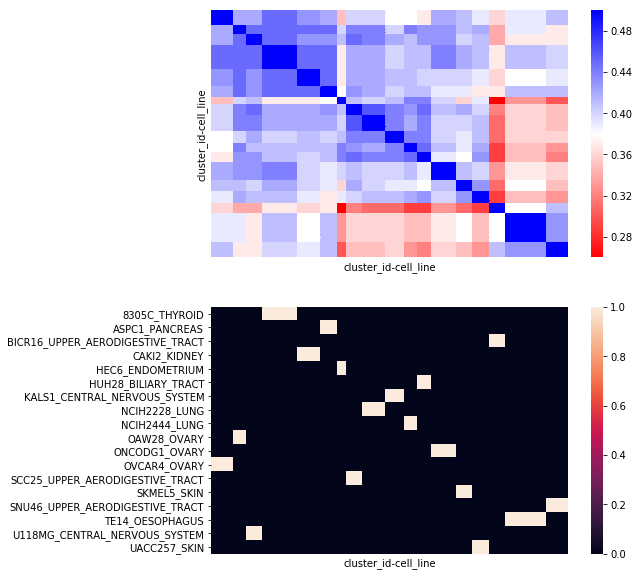

In [302]:
my_rwb = matplotlib.colors.LinearSegmentedColormap.from_list('my_rwb', [(1,0,0), (1,1,1), (0,0,1)], 1000)
fig, ax = plt.subplots(2, 1, figsize=(8,10))
sns.heatmap(program_distmat_sorted,
            xticklabels=False, 
            yticklabels=False, 
            cmap=my_rwb,
            ax=ax[0])
sns.heatmap(original_cell_line, xticklabels=False, ax=ax[1])

## Meeting with Itay 25/04/2018
TODO list:
1. Change differentially expressed definition to have only genes that have higher expression
2. Issue with separation to cell line (might be cause due to selection of genes) check this
3. Turn pipeline into universal with wrapper